In [41]:
"""
EDA - Exploratory Data Analysis
This script performs exploratory data analysis on PPMI's extracted MRI information, including:
- Data Overview (e.g. head, info)
- Data Cleaning (e.g. Missing Values, Duplicates, Outliers, Consistency)
- Feature Engineering (e.g. One-Hot Encoding, Ordinal Encoding)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr, f_oneway
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 0. Data Overview
> Reference: https://www.ppmi-info.org/

**Dataset**: PPMI (Parkinson's Progression Markers Initiative)

**Core Task**: Exploring the multimodal data for Disease Progression Prediction
- **Subtask 1**: Predict the slope of the MDS-UPDRS / MoCA score
- **Subtask 2**: Predict the time to achieving a Hoehn Yahr stage of 3 or greater
- **Subtask 3**: Joint Modeling of the two subtasks

**Columns Overview**

**1. Cortical Thickness (CTh) - aparc parcellation**

These features represent the average thickness of the cerebral cortex in various predefined anatomical regions (parcels).

* **ID**
    * `patno`: Participant ID.
    * `event_id`: Clinical Visit Label (e.g., BL, V04).
* **Left Hemisphere (lh) Regions**
    * `lh_bankssts`: Left Banks of the Superior Temporal Sulcus.
    * `lh_caudalanteriorcingulate`: Left Caudal Anterior Cingulate.
    * `lh_caudalmiddlefrontal`: Left Caudal Middle Frontal.
    * `lh_cuneus`: Left Cuneus.
    * `lh_entorhinal`: Left Entorhinal Cortex.
    * `lh_fusiform`: Left Fusiform Gyrus.
    * `lh_inferiorparietal`: Left Inferior Parietal.
    * `lh_inferiortemporal`: Left Inferior Temporal.
    * `lh_isthmuscingulate`: Left Isthmus Cingulate.
    * `lh_lateraloccipital`: Left Lateral Occipital.
    * `lh_lateralorbitofrontal`: Left Lateral Orbitofrontal.
    * `lh_lingual`: Left Lingual Gyrus.
    * `lh_medialorbitofrontal`: Left Medial Orbitofrontal.
    * `lh_middletemporal`: Left Middle Temporal.
    * `lh_parahippocampal`: Left Parahippocampal Gyrus.
    * `lh_paracentral`: Left Paracentral Lobule.
    * `lh_parsopercularis`: Left Pars Opercularis.
    * `lh_parsorbitalis`: Left Pars Orbitalis.
    * `lh_parstriangularis`: Left Pars Triangularis.
    * `lh_pericalcarine`: Left Pericalcarine Cortex.
    * `lh_postcentral`: Left Postcentral Gyrus.
    * `lh_posteriorcingulate`: Left Posterior Cingulate.
    * `lh_precentral`: Left Precentral Gyrus.
    * `lh_precuneus`: Left Precuneus.
    * `lh_rostralanteriorcingulate`: Left Rostral Anterior Cingulate.
    * `lh_rostralmiddlefrontal`: Left Rostral Middle Frontal.
    * `lh_superiorfrontal`: Left Superior Frontal.
    * `lh_superiorparietal`: Left Superior Parietal.
    * `lh_supramarginal`: Left Supramarginal Gyrus.
    * `lh_frontalpole`: Left Frontal Pole.
    * `lh_temporalpole`: Left Temporal Pole.
    * `lh_transversetemporal`: Left Transverse Temporal Gyrus.
    * `lh_insula`: Left Insula.
* **Right Hemisphere (rh) Regions**
    * `rh_bankssts`: Right Banks of the Superior Temporal Sulcus.
    * `rh_caudalanteriorcingulate`: Right Caudal Anterior Cingulate.
    * ... (all corresponding right hemisphere regions) ...
    * `rh_insula`: Right Insula.
* **Summary Measures**
    * `lh_meanthickness`: Mean Cortical Thickness of the Left Hemisphere.
    * `rh_meanthickness`: Mean Cortical Thickness of the Right Hemisphere.

---

**2. Surface Area (SA) - aparc parcellation**

These features represent the surface area of the cerebral cortex in the same anatomical regions.

* **ID**
    * `patno`: Participant ID.
    * `event_id`: Clinical Visit Label.
* **Left Hemisphere (lh) Regions**
    * `lh_bankssts`: Left Banks of the Superior Temporal Sulcus.
    * ... (all corresponding left hemisphere regions) ...
    * `lh_insula`: Left Insula.
* **Right Hemisphere (rh) Regions**
    * `rh_bankssts`: Right Banks of the Superior Temporal Sulcus.
    * ... (all corresponding right hemisphere regions) ...
    * `rh_insula`: Right Insula.
* **Summary Measures**
    * `lh_whitesurfarea`: Total White Surface Area of the Left Hemisphere.
    * `rh_whitesurfarea`: Total White Surface Area of the Right Hemisphere.

---

**3. Volume - ASEG parcellation**

These features represent the volume of various subcortical structures, cerebrospinal fluid spaces, and summary tissue types.

* **ID**
    * `patno`: Participant ID.
    * `event_id`: Clinical Visit Label.
* **Subcortical Gray Matter**
    * `left_thalamus`: Left Thalamus Volume.
    * `right_thalamus`: Right Thalamus Volume.
    * `left_caudate`: Left Caudate Volume.
    * `right_caudate`: Right Caudate Volume.
    * `left_putamen`: Left Putamen Volume.
    * `right_putamen`: Right Putamen Volume.
    * `left_pallidum`: Left Pallidum Volume.
    * `right_pallidum`: Right Pallidum Volume.
    * `left_hippocampus`: Left Hippocampus Volume.
    * `right_hippocampus`: Right Hippocampus Volume.
    * `left_amygdala`: Left Amygdala Volume.
    * `right_amygdala`: Right Amygdala Volume.
    * `left_accumbens_area`: Left Accumbens Area Volume.
    * `right_accumbens_area`: Right Accumbens Area Volume.
    * `left_ventraldc`: Left Ventral Diencephalon Volume.
    * `right_ventraldc`: Right Ventral Diencephalon Volume.
    * `subcortgrayvol`: Total Subcortical Gray Matter Volume.
* **Cerebellum**
    * `left_cerebellum_cortex`: Left Cerebellum Cortex Volume.
    * `right_cerebellum_cortex`: Right Cerebellum Cortex Volume.
    * `left_cerebellum_white_matter`: Left Cerebellum White Matter Volume.
    * `right_cerebellum_white_matter`: Right Cerebellum White Matter Volume.
* **Ventricular System & CSF**
    * `left_lateral_ventricle`: Left Lateral Ventricle Volume.
    * `right_lateral_ventricle`: Right Lateral Ventricle Volume.
    * `left_inf_lat_vent`: Left Inferior Lateral Ventricle Volume.
    * `right_inf_lat_vent`: Right Inferior Lateral Ventricle Volume.
    * `3rd_ventricle`: 3rd Ventricle Volume.
    * `4th_ventricle`: 4th Ventricle Volume.
    * `5th_ventricle`: 5th Ventricle Volume.
    * `csf`: Total Cerebrospinal Fluid Volume.
    * `left_choroid_plexus`: Left Choroid Plexus Volume.
    * `right_choroid_plexus`: Right Choroid Plexus Volume.
* **White Matter & Lesions**
    * `lhcerebralwhitemattervol`: Left Cerebral White Matter Volume.
    * `rhcerebralwhitemattervol`: Right Cerebral White Matter Volume.
    * `cerebralwhitemattervol`: Total Cerebral White Matter Volume.
    * `wm_hypointensities`: Volume of White Matter Hypointensities.
    * `left_wm_hypointensities`: Volume of Left White Matter Hypointensities.
    * `right_wm_hypointensities`: Volume of Right White Matter Hypointensities.
    * `non_wm_hypointensities`: Volume of Non-White Matter Hypointensities.
    * `left_non_wm_hypointensities`: Volume of Left Non-White Matter Hypointensities.
    * `right_non_wm_hypointensities`: Volume of Right Non-White Matter Hypointensities.
* **Corpus Callosum**
    * `cc_posterior`: Posterior Corpus Callosum Volume.
    * `cc_mid_posterior`: Mid-Posterior Corpus Callosum Volume.
    * `cc_central`: Central Corpus Callosum Volume.
    * `cc_mid_anterior`: Mid-Anterior Corpus Callosum Volume.
    * `cc_anterior`: Anterior Corpus Callosum Volume.
* **Global & Summary Volumes**
    * `estimatedtotalintracranialvol`: Estimated Total Intracranial Volume (eTIV).
    * `brainsegvol`: Brain Segmentation Volume.
    * `brainsegvolnotvent`: Brain Segmentation Volume (excluding ventricles).
    * `supratentorialvol`: Supratentorial Volume.
    * `supratentorialvolnotvent`: Supratentorial Volume (excluding ventricles).
    * `totalgrayvol`: Total Gray Matter Volume.
    * `cortexvol`: Total Cerebral Cortex Volume.
    * `lhcortexvol`: Left Cerebral Cortex Volume.
    * `rhcortexvol`: Right Cerebral Cortex Volume.
    * `maskvol`: Mask Volume.
    * `maskvol_to_etiv`: Ratio of Mask Volume to eTIV.
    * `brainsegvol_to_etiv`: Ratio of Brain Segmentation Volume to eTIV.
* **Other Structures & Measures**
    * `brain_stem`: Brain Stem Volume.
    * `optic_chiasm`: Optic Chiasm Volume.
    * `left_vessel`: Left Vessel Volume.
    * `right_vessel`: Right Vessel Volume.
    * `surfaceholes`: Total count of surface holes.
    * `lhsurfaceholes`: Count of left hemisphere surface holes.
    * `rhsurfaceholes`: Count of right hemisphere surface holes.

In [42]:
# Defining Path
data_path = './data/'
aparc_cth_path = 'origin_data_mri_APARC_CTH_20250129.csv'
aparc_sa_path = 'origin_data_mri_APARC_SA_20250129.csv'
aseg_vol_path = 'origin_data_mri_ASEG_VOL_20250129.csv'
# Load Data
aparc_cth_df = pd.read_csv(data_path + aparc_cth_path)
aparc_sa_df = pd.read_csv(data_path + aparc_sa_path)
aseg_vol_df = pd.read_csv(data_path + aseg_vol_path)
# Lowering the columns
aseg_vol_df.columns = aseg_vol_df.columns.str.lower()
aparc_cth_df.columns = aparc_cth_df.columns.str.lower()
aparc_sa_df.columns = aparc_sa_df.columns.str.lower()
# All data are from BL, but double select at here (for future use)
aparc_cth_df = aparc_cth_df[aparc_cth_df['event_id'] == 'BL']
aparc_cth_df = aparc_cth_df.drop(columns=['event_id'], errors='ignore')
aparc_sa_df = aparc_sa_df[aparc_sa_df['event_id'] == 'BL']
aparc_sa_df = aparc_sa_df.drop(columns=['event_id'], errors='ignore')
aseg_vol_df = aseg_vol_df[aseg_vol_df['event_id'] == 'BL']
aseg_vol_df = aseg_vol_df.drop(columns=['event_id'], errors='ignore')

# Data Overview
print("APARC CTH Data Overview:")
# print(aparc_cth_df.describe())
print(aparc_cth_df.shape)
print("\nAPARC SA Data Overview:")
# print(aparc_sa_df.describe())
print(aparc_sa_df.shape)
print("\nASEG VOL Data Overview:")
# print(aseg_vol_df.describe())
print(aseg_vol_df.shape)

APARC CTH Data Overview:
(1716, 71)

APARC SA Data Overview:
(1716, 71)

ASEG VOL Data Overview:
(1713, 65)


In [43]:
# 1. Merge Three MRI Datasets
mri_combined_df = aparc_cth_df.merge(aparc_sa_df, on='patno', how='outer', suffixes=('_cth', '_sa'))
mri_combined_df = mri_combined_df.merge(aseg_vol_df, on='patno', how='outer')
mri_feature_cols = [col for col in mri_combined_df.columns if col not in ['patno']]

# Check merged MRI data
print("MRI Combined Data Shape:", mri_combined_df.shape)
print("Available patients in MRI data:", mri_combined_df['patno'].nunique())

MRI Combined Data Shape: (1716, 205)
Available patients in MRI data: 1716


In [44]:
curated_path = 'origin_data_curated_cut_20250714.xlsx'
curated_df = pd.read_excel(data_path + curated_path)
curated_df.columns = curated_df.columns.str.lower()

In [45]:
test = mri_combined_df.merge(
    curated_df,
    on='patno',
    how='inner'
)

print(test[(test['event_id'] == 'BL')]['cohort'].value_counts())

cohort
1    780
4    653
2    205
3     56
Name: count, dtype: int64


In [46]:
# Select Patients
curated_patients_patnos = curated_df[(curated_df['event_id'] == 'BL') & (curated_df['cohort'] == 1)]['patno']
mri_combined_df = mri_combined_df[mri_combined_df['patno'].isin(curated_patients_patnos)]
print(mri_combined_df.shape)

(780, 205)


In [47]:
test = mri_combined_df.merge(
    curated_df,
    on='patno',
    how='inner'
)

print(test[(test['event_id'] == 'BL')]['cohort'].value_counts())

test = test[(test['event_id'] == 'BL') & (test['cohort'] == 1)]

print(test[(test['event_id'] == 'BL')]['cohort'].value_counts())

cohort
1    780
Name: count, dtype: int64
cohort
1    780
Name: count, dtype: int64


In [48]:
mri_combined_df = test[['site', 'patno', 'age', 'sex'] + mri_feature_cols]
print(mri_combined_df.shape)

(780, 208)


In [49]:
mri_combined_df.columns

Index(['site', 'patno', 'age', 'sex', 'lh_bankssts_cth',
       'lh_caudalanteriorcingulate_cth', 'lh_caudalmiddlefrontal_cth',
       'lh_cuneus_cth', 'lh_entorhinal_cth', 'lh_fusiform_cth',
       ...
       'left_ventraldc', 'supratentorialvolnotvent', 'cc_mid_anterior',
       'supratentorialvol', 'subcortgrayvol', 'right_thalamus',
       'left_lateral_ventricle', 'csf', 'surfaceholes',
       'cerebralwhitemattervol'],
      dtype='object', length=208)

In [50]:
mri_combined_df['site'].nunique()

49

# 1. Missing Values

In [51]:
mri_combined_df.isnull().sum().sort_values(ascending=False)

wm_hypointensities                 1
right_accumbens_area               1
rhsurfaceholes                     1
lhcerebralwhitemattervol           1
brainsegvolnotvent                 1
left_cerebellum_white_matter       1
left_ventraldc                     1
supratentorialvolnotvent           1
cc_mid_anterior                    1
supratentorialvol                  1
subcortgrayvol                     1
right_thalamus                     1
left_lateral_ventricle             1
csf                                1
surfaceholes                       1
cerebralwhitemattervol             1
left_wm_hypointensities            1
brain_stem                         1
left_non_wm_hypointensities        1
optic_chiasm                       1
right_wm_hypointensities           1
brainsegvol                        1
right_lateral_ventricle            1
cc_central                         1
5th_ventricle                      1
right_choroid_plexus               1
right_cerebellum_white_matter      1
l

In [52]:
mri_combined_df = mri_combined_df.dropna()
mri_combined_df.shape

(779, 208)

# 2. Duplicates

In [53]:
duplicated_number = mri_combined_df.duplicated(subset=['patno']).sum()
if duplicated_number > 0:
    print(f"Number of duplicated rows based on PATNO: {duplicated_number}")
else:
    print("No duplicated rows based on PATNO.")

No duplicated rows based on PATNO.


# 3. Outlier Check

In [54]:
mri_combined_df.describe()

,site,patno,age,sex,lh_bankssts_cth,lh_caudalanteriorcingulate_cth,lh_caudalmiddlefrontal_cth,lh_cuneus_cth,lh_entorhinal_cth,lh_fusiform_cth,lh_inferiorparietal_cth,lh_inferiortemporal_cth,lh_isthmuscingulate_cth,lh_lateraloccipital_cth,lh_lateralorbitofrontal_cth,lh_lingual_cth,lh_medialorbitofrontal_cth,lh_middletemporal_cth,lh_parahippocampal_cth,lh_paracentral_cth,lh_parsopercularis_cth,lh_parsorbitalis_cth,lh_parstriangularis_cth,lh_pericalcarine_cth,lh_postcentral_cth,lh_posteriorcingulate_cth,lh_precentral_cth,lh_precuneus_cth,lh_rostralanteriorcingulate_cth,lh_rostralmiddlefrontal_cth,lh_superiorfrontal_cth,lh_superiorparietal_cth,lh_superiortemporal_cth,lh_supramarginal_cth,lh_frontalpole_cth,lh_temporalpole_cth,lh_transversetemporal_cth,lh_insula_cth,lh_meanthickness,rh_bankssts_cth,rh_caudalanteriorcingulate_cth,rh_caudalmiddlefrontal_cth,rh_cuneus_cth,rh_entorhinal_cth,rh_fusiform_cth,rh_inferiorparietal_cth,rh_inferiortemporal_cth,rh_isthmuscingulate_cth,rh_lateraloccipital_cth,rh_lateralorbitofrontal_cth,rh_lingual_cth,rh_medialorbitofrontal_cth,rh_middletemporal_cth,rh_parahippocampal_cth,rh_paracentral_cth,rh_parsopercularis_cth,rh_parsorbitalis_cth,rh_parstriangularis_cth,rh_pericalcarine_cth,rh_postcentral_cth,rh_posteriorcingulate_cth,rh_precentral_cth,rh_precuneus_cth,rh_rostralanteriorcingulate_cth,rh_rostralmiddlefrontal_cth,rh_superiorfrontal_cth,rh_superiorparietal_cth,rh_superiortemporal_cth,rh_supramarginal_cth,rh_frontalpole_cth,rh_temporalpole_cth,rh_transversetemporal_cth,rh_insula_cth,rh_meanthickness,lh_bankssts_sa,lh_caudalanteriorcingulate_sa,lh_caudalmiddlefrontal_sa,lh_cuneus_sa,lh_entorhinal_sa,lh_fusiform_sa,lh_inferiorparietal_sa,lh_inferiortemporal_sa,lh_isthmuscingulate_sa,lh_lateraloccipital_sa,lh_lateralorbitofrontal_sa,lh_lingual_sa,lh_medialorbitofrontal_sa,lh_middletemporal_sa,lh_parahippocampal_sa,lh_paracentral_sa,lh_parsopercularis_sa,lh_parsorbitalis_sa,lh_parstriangularis_sa,lh_pericalcarine_sa,lh_postcentral_sa,lh_posteriorcingulate_sa,lh_precentral_sa,lh_precuneus_sa,lh_rostralanteriorcingulate_sa,lh_rostralmiddlefrontal_sa,lh_superiorfrontal_sa,lh_superiorparietal_sa,lh_superiortemporal_sa,lh_supramarginal_sa,lh_frontalpole_sa,lh_temporalpole_sa,lh_transversetemporal_sa,lh_insula_sa,lh_whitesurfarea,rh_bankssts_sa,rh_caudalanteriorcingulate_sa,rh_caudalmiddlefrontal_sa,rh_cuneus_sa,rh_entorhinal_sa,rh_fusiform_sa,rh_inferiorparietal_sa,rh_inferiortemporal_sa,rh_isthmuscingulate_sa,rh_lateraloccipital_sa,rh_lateralorbitofrontal_sa,rh_lingual_sa,rh_medialorbitofrontal_sa,rh_middletemporal_sa,rh_parahippocampal_sa,rh_paracentral_sa,rh_parsopercularis_sa,rh_parsorbitalis_sa,rh_parstriangularis_sa,rh_pericalcarine_sa,rh_postcentral_sa,rh_posteriorcingulate_sa,rh_precentral_sa,rh_precuneus_sa,rh_rostralanteriorcingulate_sa,rh_rostralmiddlefrontal_sa,rh_superiorfrontal_sa,rh_superiorparietal_sa,rh_superiortemporal_sa,rh_supramarginal_sa,rh_frontalpole_sa,rh_temporalpole_sa,rh_transversetemporal_sa,rh_insula_sa,rh_whitesurfarea,left_wm_hypointensities,brain_stem,left_non_wm_hypointensities,optic_chiasm,right_wm_hypointensities,brainsegvol,right_lateral_ventricle,cc_central,5th_ventricle,right_choroid_plexus,right_cerebellum_white_matter,left_vessel,left_cerebellum_cortex,maskvol_to_etiv,maskvol,totalgrayvol,left_choroid_plexus,right_inf_lat_vent,left_pallidum,left_thalamus,right_ventraldc,rhcortexvol,right_non_wm_hypointensities,brainsegvol_to_etiv,right_amygdala,left_amygdala,estimatedtotalintracranialvol,4th_ventricle,left_inf_lat_vent,cortexvol,right_pallidum,lhcortexvol,cc_anterior,cc_posterior,left_accumbens_area,right_vessel,right_cerebellum_cortex,left_putamen,3rd_ventricle,non_wm_hypointensities,right_caudate,cc_mid_posterior,lhsurfaceholes,left_hippocampus,right_hippocampus,left_caudate,rhcerebralwhitemattervol,right_putamen,wm_hypointensities,right_accumbens_area,rhsurfaceholes,lhcerebralwhitemattervol,brainsegvolnotvent,left_cerebellum_white_matter,left_ventraldc,suprate

In [55]:
# MRI Quality Check
def check_mri_data_quality(df, feature_cols):
    """Check MRI data quality"""
    quality_report = []
    
    for col in feature_cols:
        missing_rate = df[col].isna().sum() / len(df) * 100
        zero_rate = (df[col] == 0).sum() / len(df) * 100

        # Outlier Management
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_count = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        outlier_rate = outlier_count / len(df) * 100
        
        quality_report.append({
            'feature': col,
            'missing_rate': missing_rate,
            'zero_rate': zero_rate,
            'outlier_rate': outlier_rate,
            'mean': df[col].mean(),
            'std': df[col].std()
        })
    
    return pd.DataFrame(quality_report)

# Check MRI data quality
mri_quality = check_mri_data_quality(mri_combined_df, mri_feature_cols)

# Filter high-quality features (missing < 30%, outlier < 20%)
high_quality_mri_features = mri_quality[
    (mri_quality['missing_rate'] < 30) & 
    (mri_quality['outlier_rate'] < 20)
]['feature'].tolist()

print(f"High quality MRI features: {len(high_quality_mri_features)} / {len(mri_feature_cols)}")

# Display quality report summary
print("\nMRI Data Quality Summary:")
print(mri_quality[['missing_rate', 'zero_rate', 'outlier_rate']].describe())

High quality MRI features: 204 / 204

MRI Data Quality Summary:
       missing_rate   zero_rate  outlier_rate
count         204.0  204.000000    204.000000
mean            0.0    3.082761      3.109190
std             0.0   16.841948      2.079936
min             0.0    0.000000      0.000000
25%             0.0    0.000000      1.540436
50%             0.0    0.000000      2.567394
75%             0.0    0.000000      4.492940
max             0.0  100.000000     11.296534


# 4. Feature Selection

In [56]:
mri_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 779 entries, 0 to 4909
Columns: 208 entries, site to cerebralwhitemattervol
dtypes: float64(137), int64(71)
memory usage: 1.2 MB


In [57]:
# -*- coding: utf-8 -*-
"""
Module 1: Residualisation for Biological Correction

This script contains functions to perform modality-specific scaling corrections
on MRI data by regressing out the effects of biological confounders like
total intracranial volume (eTIV) or mean cortical thickness.
"""
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def residualize_feature(df, y_col, covars, log_y=False, log_covars=None):
    required_cols = [y_col] + covars
    temp_df = df[required_cols].dropna().copy()
    out = pd.Series(index=df.index, dtype=np.float64)  

    if temp_df.empty:
        return out

    X = pd.get_dummies(temp_df[covars], drop_first=True, dtype=float)
    if log_covars:
        for c in log_covars:
            if c in X.columns:
                X[c] = np.log1p(np.clip(X[c], 0, None))
    y = temp_df[y_col].astype(float)
    if log_y:
        y = np.log1p(np.clip(y, 0, None))

    try:
        lr = LinearRegression().fit(X, y)
        residuals = y - lr.predict(X)
        out.loc[temp_df.index] = residuals 
        return out
    except Exception as e:
        print(f"❌ Failed to residualise {y_col}: {e}")
        return out


def residualize(df, y_cols, covars, log_y=False, log_covars=None, drop_na=True, prefix="res_"):
    """
    Per-feature linear residualisation:
    y ~ covars (optionally log1p for y and selected covars).
    Returns a new df with residual columns added, and the list of new column names.
    """
    print(f"🔧 Fixed residualisation: {len(y_cols)} features")
    
    df2 = df.copy()
    new_cols = []
    
    X = df2[covars].copy()
    X = pd.get_dummies(X, drop_first=True, dtype=float)
    
    if log_covars:
        for c in log_covars:
            if c in X.columns:
                X[c] = np.log1p(np.clip(X[c], 0, None))
    
    if drop_na:
        valid_mask = X.notna().all(axis=1)
        for y_col in y_cols:
            if y_col in df2.columns:
                valid_mask = valid_mask & df2[y_col].notna()
        

        if not valid_mask.all():
            print(f"⚠️  Removing {(~valid_mask).sum()} samples with missing values")
            df2 = df2[valid_mask].copy()
            X = X[valid_mask].copy()
    
    assert X.isnull().sum().sum() == 0, "❌ Covariates still have missing values!"
    
    for y_col in y_cols:
        if y_col not in df2.columns:
            continue
            
        y = df2[y_col].copy().astype(float)
        
        if y.isnull().sum() > 0:
            print(f"⚠️  Skipping {y_col}: still has {y.isnull().sum()} missing values")
            continue
        
        if log_y:
            y = np.log1p(np.clip(y, 0, None))
        
        try:
            lr = LinearRegression()
            lr.fit(X, y)
            y_pred = lr.predict(X)
            residuals = y - y_pred
            
            res_col_name = f"{prefix}{y_col}"
            df2[res_col_name] = residuals
            new_cols.append(res_col_name)
            
            assert df2[res_col_name].isnull().sum() == 0, f"❌ {res_col_name} has missing values!"
            
        except Exception as e:
            print(f"❌ Failed to residualise {y_col}: {e}")
            continue
    
    print(f"✅ Successfully residualised {len(new_cols)} features")
    return df2, new_cols


def apply_brain_corrections(df, all_mri_features):
    dfc = df.copy()
    corrected = []

    etiv = next((c for c in ['estimatedtotalintracranialvol', 'etiv', 'totalintracranialvol'] if c in dfc.columns), None)
    mean_cth_cols = [c for c in ['lh_meanthickness', 'rh_meanthickness'] if c in dfc.columns]
    
    total_sa = None
    if 'lh_whitesurfarea' in dfc.columns and 'rh_whitesurfarea' in dfc.columns:
        dfc['total_whitesurfarea'] = dfc['lh_whitesurfarea'] + dfc['rh_whitesurfarea']
        total_sa = 'total_whitesurfarea'

    cols = dfc.columns
    
    # 1. Thickness Features (highest priority)
    thickness_cols = []
    for c in cols:
        if any(k in c.lower() for k in ['_cth', 'thick']) or c in ['lh_meanthickness', 'rh_meanthickness']:
            thickness_cols.append(c)
    thickness_cols = sorted(list(set(thickness_cols)))
    
    # 2. Surface Features
    area_cols = []
    for c in cols:
        if c not in thickness_cols:  
            if (any(k in c.lower() for k in ['_sa', 'surfarea', '_area']) or 
                c in ['lh_whitesurfarea', 'rh_whitesurfarea']) and \
               not c.endswith('_to_etiv'):
                area_cols.append(c)
    area_cols = sorted(list(set(area_cols)))
    
    # 3. Volume Features
    vol_cols = []
    for c in cols:
        if c not in thickness_cols and c not in area_cols:  
            if ('vol' in c.lower()) or \
               any(k in c.lower() for k in [
                   'thalamus','caudate','putamen','pallidum','amygdala',
                   'hippocampus','accumbens','ventricle','ventraldc',
                   'choroid_plexus','brain_stem','cortexvol','totalgrayvol',
                   'cerebellum','whitematter','wm_hypointensities','non_wm_hypointensities',
                   'corpuscallosum','cc_','optic_chiasm'
               ]):
                if not c.endswith('_to_etiv'):
                    vol_cols.append(c)
    vol_cols = sorted(list(set(vol_cols)))

    print(f"Feature Classification:")
    print(f"  Thickness Features: {len(thickness_cols)}")
    print(f"  Surface Features: {len(area_cols)}")
    print(f"  Volume Features: {len(vol_cols)}")

    all_classified = thickness_cols + area_cols + vol_cols
    unique_classified = list(set(all_classified))
    
    if len(all_classified) != len(unique_classified):
        print(f"❌ Duplicate Features! Total: {len(all_classified)}, Unique: {len(unique_classified)}")
        from collections import Counter
        counts = Counter(all_classified)
        for feature, count in counts.items():
            if count > 1:
                print(f"  Duplicate Feature: {feature} (Count: {count})")
        return dfc, []
    else:
        print(f"✅ No Duplicate Features! Total Classified Features: {len(unique_classified)}")

    # === Residualization Process ===

    # Thickness Residualization
    if thickness_cols and mean_cth_cols:
        print("🔧 Residualizing Thickness Features...")
        dfc, res_cth = residualize(
            dfc, thickness_cols, 
            covars=mean_cth_cols,
            log_y=False, prefix="res_"
        )
        corrected.extend(res_cth)

    # Surface Residualization
    if area_cols:
        covars_area = []
        if total_sa: covars_area.append(total_sa)
        if etiv: covars_area.append(etiv)
        
        if covars_area:
            print("🔧 Residualizing Surface Features...")
            dfc, res_area = residualize(
                dfc, area_cols,
                covars=covars_area,
                log_y=True, log_covars=covars_area, prefix="res_"
            )
            corrected.extend(res_area)

    # Volume Residualization
    if vol_cols and etiv:
        print("🔧 Residualizing Volume Features...")
        dfc, res_vol = residualize(
            dfc, vol_cols,
            covars=[etiv],
            log_y=True, log_covars=[etiv], prefix="res_"
        )
        corrected.extend(res_vol)

    # 🔍 Final Check for Duplicates in Corrected List
    print(f"\n🔍 Checking for Duplicates in Corrected Feature List:")
    print(f"  Total Residual Features: {len(corrected)}")
    print(f"  Unique Residual Features: {len(set(corrected))}")

    if len(corrected) != len(set(corrected)):
        from collections import Counter
        corr_counts = Counter(corrected)
        print(f"❌ Duplicates Found in Corrected Feature List:")
        for feature, count in corr_counts.items():
            if count > 1:
                print(f"  {feature}: {count} times")

        # Remove duplicates while preserving order
        corrected = list(dict.fromkeys(corrected))
        print(f"✅ After Removing Duplicates: {len(corrected)} Unique Features")
    else:
        print(f"✅ No Duplicates Found in Corrected List")

    # Final Check
    missing_count = dfc.isnull().sum().sum()
    if missing_count > 0:
        print(f"⚠️  Generated {missing_count} Missing Values")
    else:
        print(f"✅ No Missing Values Generated")

    aux = {
        'etiv_col': etiv,
        'total_sa_col': total_sa,
        'mean_cth_cols': mean_cth_cols,
        'thickness_cols': thickness_cols,
        'area_cols': area_cols,
        'vol_cols': vol_cols
    }

    print(f"✅ After Removing Duplicates: {len(corrected)} Unique Features")
    return dfc, corrected

In [58]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from statsmodels.stats.multitest import multipletests
from scipy.stats import f_oneway

def _ensure_numeric(df):
    df = df.copy()
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def r2_site_per_feature(X_df: pd.DataFrame, site: pd.Series) -> pd.Series:
    """R² of site (one-hot) explaining each feature."""
    X_df = _ensure_numeric(X_df)
    site = site.astype(str)
    site_d = pd.get_dummies(site, drop_first=True)
    r2 = {}
    for c in X_df.columns:
        y = X_df[c].values
        if not np.isfinite(y).all() or np.std(y)==0:
            r2[c] = np.nan
            continue
        lr = LinearRegression().fit(site_d, y)
        r2[c] = lr.score(site_d, y)
    s = pd.Series(r2).dropna()
    return s

def anova_by_site(X_df: pd.DataFrame, site: pd.Series):
    """One-way ANOVA across sites per feature + FDR."""
    X_df = _ensure_numeric(X_df)
    site = site.astype(str)
    groups = [X_df.loc[site==s] for s in site.unique()]
    pvals = {}
    for c in X_df.columns:
        cols = [g[c].dropna().values for g in groups if c in g]
        cols = [v for v in cols if len(v) >= 3]
        if len(cols) < 2:
            pvals[c] = np.nan
            continue
        try:
            _, p = f_oneway(*cols)
        except Exception:
            p = np.nan
        pvals[c] = p
    pv = pd.Series(pvals).dropna()
    if len(pv) == 0:
        return pv, pv, pv
    rej, qvals, _ , _ = multipletests(pv.values, method="fdr_bh")
    q = pd.Series(qvals, index=pv.index)
    sig = pd.Series(rej.astype(bool), index=pv.index)
    return pv, q, sig

def site_predictability_score(X_df: pd.DataFrame, site: pd.Series, cv_splits=5, random_state=42):
    """CV accuracy to predict site (should be near baseline after ComBat)."""
    X_df = _ensure_numeric(X_df).fillna(X_df.median(numeric_only=True))
    site = site.astype(str)
    majority_acc = site.value_counts(normalize=True).max()
    pipe = make_pipeline(StandardScaler(with_mean=True, with_std=True),
                         LogisticRegression(max_iter=200, multi_class="auto"))
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    acc = cross_val_score(pipe, X_df.values, site.values, cv=cv, scoring="accuracy")
    return acc.mean(), acc.std(), majority_acc

def age_sex_preservation(X_df: pd.DataFrame, age: pd.Series=None, sex: pd.Series=None):
    """
    Evaluate the linear association strength (R²) with age/sex. Returns R² for each column and (optionally) coefficients.
    Sex will be mapped to 0/1 (F=0, M=1) if it's a string.
    """
    X_df = _ensure_numeric(X_df)
    covars = {}
    if age is not None:
        covars["age"] = pd.to_numeric(age, errors="coerce")
    if sex is not None:
        s = sex.copy()
        if s.dtype == object:
            s = s.str.lower().map({"m":1, "male":1, "f":0, "female":0})
        covars["sex"] = pd.to_numeric(s, errors="coerce")
    if not covars:
        raise ValueError("Provide age and/or sex to evaluate biological preservation.")
    C = pd.DataFrame(covars).astype(float)
    valid = C.notna().all(axis=1)
    C = C.loc[valid]
    X = X_df.loc[valid]
    C = pd.get_dummies(C, drop_first=True) 

    r2 = {}
    coefs = {}
    for c in X.columns:
        y = X[c].values
        if not np.isfinite(y).all() or np.std(y)==0:
            r2[c] = np.nan
            coefs[c] = np.full(C.shape[1], np.nan)
            continue
        lr = LinearRegression().fit(C.values, y)
        r2[c] = lr.score(C.values, y)
        coefs[c] = lr.coef_
    r2 = pd.Series(r2).dropna()
    B = pd.DataFrame(coefs).T  
    B.columns = [f"coef_{i}" for i in range(B.shape[1])]
    return r2, B

def evaluate_harmonization(
    df_pre: pd.DataFrame, df_post: pd.DataFrame, feature_cols: list,
    site_col: str, age_col: str=None, sex_col: str=None, verbose=True
):
    """Main function: Outputs various metrics and provides a brief conclusion."""
    # Align indices & columns
    common_idx = df_pre.index.intersection(df_post.index)
    X_pre = df_pre.loc[common_idx, feature_cols].copy()
    X_post = df_post.loc[common_idx, feature_cols].copy()
    site = df_pre.loc[common_idx, site_col] 
    # 1) R²_site
    r2_pre = r2_site_per_feature(X_pre, site)
    r2_post = r2_site_per_feature(X_post, site)
    # 2) ANOVA + FDR
    p_pre, q_pre, sig_pre = anova_by_site(X_pre, site)
    p_post, q_post, sig_post = anova_by_site(X_post, site)
    prop_sig_pre = float(sig_pre.mean()) if len(sig_pre) else np.nan
    prop_sig_post = float(sig_post.mean()) if len(sig_post) else np.nan
    # 3) Site
    acc_pre, acc_std_pre, maj_pre = site_predictability_score(X_pre, site)
    acc_post, acc_std_post, maj_post = site_predictability_score(X_post, site)
    # 4) Biomedical Preservation
    bio = {}
    if age_col or sex_col:
        age = df_pre.loc[common_idx, age_col] if age_col else None
        sex = df_pre.loc[common_idx, sex_col] if sex_col else None
        r2_age_pre, B_pre = age_sex_preservation(X_pre, age, sex)
        r2_age_post, B_post = age_sex_preservation(X_post, age, sex)
        common_feats = r2_age_pre.index.intersection(r2_age_post.index)
        delta_r2_med = (r2_age_post.loc[common_feats] - r2_age_pre.loc[common_feats]).median()
        common_coef_rows = B_pre.dropna().index.intersection(B_post.dropna().index)
        coef_delta = (B_post.loc[common_coef_rows].values - B_pre.loc[common_coef_rows].values)
        coef_delta_l2_med = np.median(np.linalg.norm(coef_delta, axis=1)) if coef_delta.size else np.nan
        bio = {
            "age_sex_r2_median_pre": float(r2_age_pre.median()) if len(r2_age_pre) else np.nan,
            "age_sex_r2_median_post": float(r2_age_post.median()) if len(r2_age_post) else np.nan,
            "delta_r2_median": float(delta_r2_med) if pd.notna(delta_r2_med) else np.nan,
            "coef_delta_l2_median": float(coef_delta_l2_med) if pd.notna(coef_delta_l2_med) else np.nan
        }

    summary = {
        "r2_site_median_pre": float(r2_pre.median()) if len(r2_pre) else np.nan,
        "r2_site_median_post": float(r2_post.median()) if len(r2_post) else np.nan,
        "r2_site_q90_pre": float(r2_pre.quantile(0.9)) if len(r2_pre) else np.nan,
        "r2_site_q90_post": float(r2_post.quantile(0.9)) if len(r2_post) else np.nan,
        "anova_sig_prop_pre(FDR<0.05)": prop_sig_pre,
        "anova_sig_prop_post(FDR<0.05)": prop_sig_post,
        "site_cls_acc_pre": float(acc_pre),
        "site_cls_acc_post": float(acc_post),
        "site_cls_acc_std_pre": float(acc_std_pre),
        "site_cls_acc_std_post": float(acc_std_post),
        "majority_baseline": float(maj_pre),
    }
    summary.update(bio)

    if verbose:
        print("\n=== Harmonization Evaluation ===")
        print(f"R²_site median:  pre={summary['r2_site_median_pre']:.3f}  → post={summary['r2_site_median_post']:.3f}")
        print(f"R²_site 90th %:  pre={summary['r2_site_q90_pre']:.3f}  → post={summary['r2_site_q90_post']:.3f}")
        print(f"ANOVA (FDR<0.05) proportion: pre={prop_sig_pre:.3f}  → post={prop_sig_post:.3f}")
        print(f"Site classification acc (CV): pre={summary['site_cls_acc_pre']:.3f}  → post={summary['site_cls_acc_post']:.3f}")
        print(f"Majority-class baseline: {summary['majority_baseline']:.3f}")
        if bio:
            print(f"Age/Sex R² median: pre={summary['age_sex_r2_median_pre']:.3f} → post={summary['age_sex_r2_median_post']:.3f}")
            print(f"ΔR² (median): {summary['delta_r2_median']:.3f}  |  Δcoef L2 (median): {summary['coef_delta_l2_median']:.3f}")

        ok_r2 = (summary['r2_site_median_post'] < 0.10) or (summary['r2_site_median_post'] < summary['r2_site_median_pre'] * 0.6)
        ok_anova = (prop_sig_post <= 0.05) or (prop_sig_post <= prop_sig_pre * 0.5)
        ok_cls = summary['site_cls_acc_post'] <= (summary['majority_baseline'] + 0.05)
        verdict = "PASS" if (ok_r2 and ok_anova and ok_cls) else "PARTIAL" if (ok_r2 or ok_anova or ok_cls) else "FAIL"
        print(f"\nVerdict: {verdict}  (R²:{ok_r2}, ANOVA:{ok_anova}, Cls:{ok_cls})")

    return {
        "summary": summary,
        "r2_site_pre": r2_pre, "r2_site_post": r2_post,
        "anova_p_pre": p_pre, "anova_q_pre": q_pre, "anova_sig_pre": sig_pre,
        "anova_p_post": p_post, "anova_q_post": q_post, "anova_sig_post": sig_post,
    }


In [59]:
# -*- coding: utf-8 -*-
"""
Module 2: ComBat for Technical Correction

This script contains functions to apply ComBat harmonization to remove
site effects from imaging data. It includes robust pre-checks to handle
common issues like zero-variance features and small batches, preventing
the generation of NaN values.
"""
import pandas as pd
import numpy as np
from neuroHarmonize import harmonizationLearn, harmonizationApply

def apply_combat(df, feature_cols, meta_cols):
    """
    Main function for this module. Applies ComBat harmonization.
    
    Args:
        df (pd.DataFrame): The input dataframe, ideally after residualisation.
        feature_cols (list): A list of column names for features to be harmonized.
        meta_cols (tuple): A tuple of metadata columns, expected to be 
                           ('site', 'age', 'sex').
                           
    Returns:
        tuple: A tuple containing:
            - pd.DataFrame: The dataframe with new 'h_*' columns added.
            - list: A list of the names of the newly created harmonized features.
    """
    print("\n--- Step 2: Applying ComBat Harmonization ---")
    
    # --- 1. Prepare data for ComBat ---
    combat_input_cols = feature_cols + list(meta_cols)
    combat_ready_df = df[combat_input_cols].dropna()
    print(f"Found {len(combat_ready_df)} samples with complete data for ComBat.")
    
    # Initialize the output dataframe and feature list
    df_after_combat = df.copy()
    harmonized_features_final = []

    if combat_ready_df.empty or len(combat_ready_df) < 10:
        print("⚠️ ComBat skipped: Not enough complete data.")
    else:
        # --- 2. Robust Pre-checks for ComBat ---
        Xc = combat_ready_df[feature_cols].astype(float).copy()
        covars = combat_ready_df[list(meta_cols)].copy()
        batch_col_name = meta_cols[0]
        covars.rename(columns={batch_col_name: "SITE"}, inplace=True)
        
        # Clean covariates robustly
        for c in covars.columns:
            if c != 'SITE':
                covars[c] = pd.to_numeric(covars[c], errors='coerce')
        valid_idx = covars.drop(columns=['SITE'], errors='ignore').notna().all(axis=1)
        Xc = Xc.loc[valid_idx]
        covars = covars.loc[valid_idx]

        # Filter features with near-zero variance (global or per-batch)
        global_std = Xc.std(ddof=0)
        near_zero_cols = global_std[global_std < 1e-6].index.tolist()
        if near_zero_cols:
            print(f"⚠️ Removing {len(near_zero_cols)} near-zero-variance features (global).")
            Xc = Xc.drop(columns=near_zero_cols)

        # Filter small batches (sites with < 3 samples are unstable for variance adjustment)
        batch_counts = covars['SITE'].value_counts()
        small_batches = batch_counts[batch_counts < 3].index.tolist()
        print(small_batches)
        if small_batches:
            print(f"⚠️ Removing {len(small_batches)} small batches (<3 samples): {small_batches}")
            keep_idx = covars[~covars['SITE'].isin(small_batches)].index
            Xc = Xc.loc[keep_idx]
            covars = covars.loc[keep_idx]

            # --- 3. Run ComBat if conditions are met ---
    if Xc.shape[1] > 0 and covars['SITE'].nunique() > 1:
        try:
            model, data_harmonized = harmonizationLearn(Xc.values, covars)

            # Generate h_* columns (without overwriting original columns)
            harmonized_feature_names = [f"h_{c}" for c in Xc.columns]
            harmonized_df = pd.DataFrame(data_harmonized, index=Xc.index, columns=harmonized_feature_names)
            df_after_combat = df_after_combat.join(harmonized_df)
            harmonized_features_final = harmonized_feature_names
            print(f"✅ ComBat completed. Generated {len(harmonized_features_final)} harmonized features.")

            # Evaluate: pre/post h_* Column，and Align to harmonized_df ===
            idx_eval = harmonized_df.index

            # pre：Draw meta and original features (res_*), then rename columns to h_* to align with post
            pre_eval = df.loc[idx_eval, list(meta_cols) + Xc.columns.tolist()].copy()
            rename_map = {c: f"h_{c}" for c in Xc.columns}
            pre_eval.rename(columns=rename_map, inplace=True)

            # post：Draw meta and ComBat (h_*) from df_after_combat
            post_eval = df_after_combat.loc[idx_eval, list(meta_cols) + harmonized_feature_names].copy()

            # Evaluate: Use the same h_* feature columns for assessment
            eval_out = evaluate_harmonization(
                df_pre=pre_eval,              
                df_post=post_eval,            
                feature_cols=harmonized_feature_names,
                site_col=meta_cols[0],
                age_col=meta_cols[1],
                sex_col=meta_cols[2],
                verbose=True
            )


        except Exception as e:
            print(f"❌ ComBat failed during execution: {e}.")
            harmonized_features_final = []
    else:
        print("❌ ComBat skipped: Not enough features or batches left after pre-checks.")
        harmonized_features_final = []

    # --- 4. Fallback if ComBat failed or was skipped ---
    if not harmonized_features_final:
        print("Proceeding with non-harmonized residual features for PCA (creating h_* copies).")
        # Fallback 后
        harmonized_feature_names = [f"h_{c}" for c in feature_cols]
        for src, dst in zip(feature_cols, harmonized_feature_names):
            df_after_combat[dst] = df_after_combat[src]

        common_idx = df_after_combat.dropna(subset=harmonized_feature_names).index

        pre_eval = df.loc[common_idx, list(meta_cols) + feature_cols].copy()
        pre_eval.rename(columns={c: f"h_{c}" for c in feature_cols}, inplace=True)

        post_eval = df_after_combat.loc[common_idx, list(meta_cols) + harmonized_feature_names].copy()

        eval_out = evaluate_harmonization(
            df_pre=pre_eval,
            df_post=post_eval,
            feature_cols=harmonized_feature_names,
            site_col=meta_cols[0],
            age_col=meta_cols[1],
            sex_col=meta_cols[2],
            verbose=True
        )

    print("\nEvaluation summary:")
    for k, v in eval_out["summary"].items():
        print(f"{k}: {v}")

    return df_after_combat, harmonized_features_final



In [ ]:
"""
Module 3: PCA for Dimensionality Reduction and Analysis

This script provides functions to perform Principal Component Analysis (PCA)
on high-dimensional feature sets. It includes a comprehensive visualization
suite to help determine the optimal number of components.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def analyze_pca_with_plots(df, features, max_components=50):
    """
    Performs a full PCA analysis and generates a suite of plots to help
    decide the optimal number of components to retain.
    """
    print("\n--- Running detailed PCA analysis with visualizations ---")
    
    # Data preparation for this analysis
    feature_data = df[features].dropna()
    if feature_data.empty:
        print("⚠️ Cannot generate PCA plots: no complete data.")
        return None

    scaler = StandardScaler()
    feature_data_scaled = scaler.fit_transform(feature_data)

    max_comp = min(max_components, len(features), len(feature_data) - 1)
    if max_comp < 1:
        print("⚠️ Cannot generate PCA plots: not enough samples or features.")
        return None

    pca_full = PCA(n_components=max_comp)
    pca_full.fit(feature_data_scaled)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(14, 12))

    # 1. Scree (eigenvalues)
    ax1 = plt.subplot(2, 2, 1)
    eigenvalues = pca_full.explained_variance_
    components = range(1, len(eigenvalues) + 1)
    plt.plot(components, eigenvalues, 'bo-', markersize=6, linewidth=2)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Kaiser criterion (eigenvalue=1)')
    plt.xlabel('Principal Component'); plt.ylabel('Eigenvalue')
    plt.title('Scree Plot (Eigenvalues)'); plt.grid(True, alpha=0.3); plt.legend()

    # elbow (simple diff heuristic)
    differences = np.diff(eigenvalues)
    elbow_point = np.argmin(differences) + 2
    plt.axvline(x=elbow_point, color='g', linestyle='--', alpha=0.7, label=f'Elbow point: PC{elbow_point}')
    plt.legend()

    # 2. Individual explained variance
    ax2 = plt.subplot(2, 2, 2)
    explained_var_ratio = pca_full.explained_variance_ratio_
    plt.plot(components, explained_var_ratio, 'ro-', markersize=6, linewidth=2)
    plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio')
    plt.title('Individual Explained Variance'); plt.grid(True, alpha=0.3)

    # 3. Cumulative explained variance
    ax3 = plt.subplot(2, 2, 3)
    cumsum_var = np.cumsum(explained_var_ratio)
    plt.plot(components, cumsum_var, 'go-', markersize=6, linewidth=2)
    for y, name in [(0.80,'80%'), (0.85,'85%'), (0.90,'90%'), (0.95,'95%')]:
        plt.axhline(y=y, color='grey', linestyle='--', alpha=0.7, label=f'{name} variance')
    pc_80 = np.argmax(cumsum_var >= 0.80) + 1
    pc_85 = np.argmax(cumsum_var >= 0.85) + 1
    pc_90 = np.argmax(cumsum_var >= 0.90) + 1
    pc_95 = np.argmax(cumsum_var >= 0.95) + 1
    for x in [pc_80, pc_85, pc_90, pc_95]:
        plt.axvline(x=x, color='grey', linestyle=':', alpha=0.5)
    plt.xlabel('Principal Component'); plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance'); plt.grid(True, alpha=0.3); plt.legend()

    # 4. Top-k bars
    ax4 = plt.subplot(2, 2, 4)
    top_10 = min(10, len(explained_var_ratio))
    bars = plt.bar(range(1, top_10 + 1), explained_var_ratio[:top_10], alpha=0.7, edgecolor='navy')
    plt.xlabel('Principal Component'); plt.ylabel('Explained Variance Ratio')
    plt.title(f'Top {top_10} Components - Explained Variance'); plt.grid(True, alpha=0.3, axis='y')
    for i, b in enumerate(bars):
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2., h + 0.001, f'{h:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout(pad=3.0) 
    plt.show()

    # --- Text Summary ---
    print("\n" + "="*50)
    print("PCA Analysis Summary")
    print("="*50)
    print(f"Total features analyzed: {len(features)}")
    print(f"Samples used for PCA: {len(feature_data)}")

    recommendations = {
        'Kaiser Criterion (Eigenvalue≥1)': int(np.sum(eigenvalues >= 1)),
        '80% Variance Threshold': int(np.argmax(cumsum_var >= 0.80) + 1),
        '90% Variance Threshold': int(np.argmax(cumsum_var >= 0.90) + 1),
    }
    print("\nRecommended number of components based on different criteria:")
    for method, num_comp in recommendations.items():
        print(f"- {method}: {num_comp} components")
        
    return pca_full, scaler, recommendations


def apply_pca(df, feature_cols, optimal_n_components=10):
    """
    Main function for this module. Applies PCA and attaches components to the dataframe.
    """
    print("\n--- Step 3: Applying PCA for Dimensionality Reduction ---")
    
    # Use only samples that are complete for the final PCA step
    pca_ready_df = df[feature_cols].dropna()
    print(f"Running PCA on {len(pca_ready_df)} complete samples.")

    if pca_ready_df.empty or len(pca_ready_df) < optimal_n_components:
        print(f"❌ PCA failed: Not enough complete data ({len(pca_ready_df)} samples).")
        return df, []
        
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(pca_ready_df)
    
    n_components = min(optimal_n_components, len(feature_cols), len(pca_ready_df)-1)
    if n_components < 1:
        print("❌ PCA failed: Not enough samples or features to select any component.")
        return df, []

    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data_scaled)
    
    pca_feature_names = [f'MRI_PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pca_data, index=pca_ready_df.index, columns=pca_feature_names)
    
    final_df = df.join(pca_df)
    
    print(f"✅ PCA completed. Generated {len(pca_feature_names)} PCs explaining {pca.explained_variance_ratio_.sum():.1%} of variance.")
    return final_df, pca_feature_names

Total MRI features to process: 204
🚀 STARTING FULL MRI FEATURE PROCESSING PIPELINE 🚀
Feature Classification:
  Thickness Features: 70
  Surface Features: 73
  Volume Features: 52
✅ No Duplicate Features! Total Classified Features: 195
🔧 Residualizing Thickness Features...
🔧 Fixed residualisation: 70 features
✅ Successfully residualised 70 features
🔧 Residualizing Surface Features...
🔧 Fixed residualisation: 73 features
✅ Successfully residualised 73 features
🔧 Residualizing Volume Features...
🔧 Fixed residualisation: 52 features
✅ Successfully residualised 52 features

🔍 Checking for Duplicates in Corrected Feature List:
  Total Residual Features: 195
  Unique Residual Features: 195
✅ No Duplicates Found in Corrected List
✅ No Missing Values Generated
✅ After Removing Duplicates: 195 Unique Features

--- Step 2: Applying ComBat Harmonization ---
Found 779 samples with complete data for ComBat.
⚠️ Removing 8 near-zero-variance features (global).
[16, 60, 30, 11, 15, 71]
⚠️ Removing 6 sm

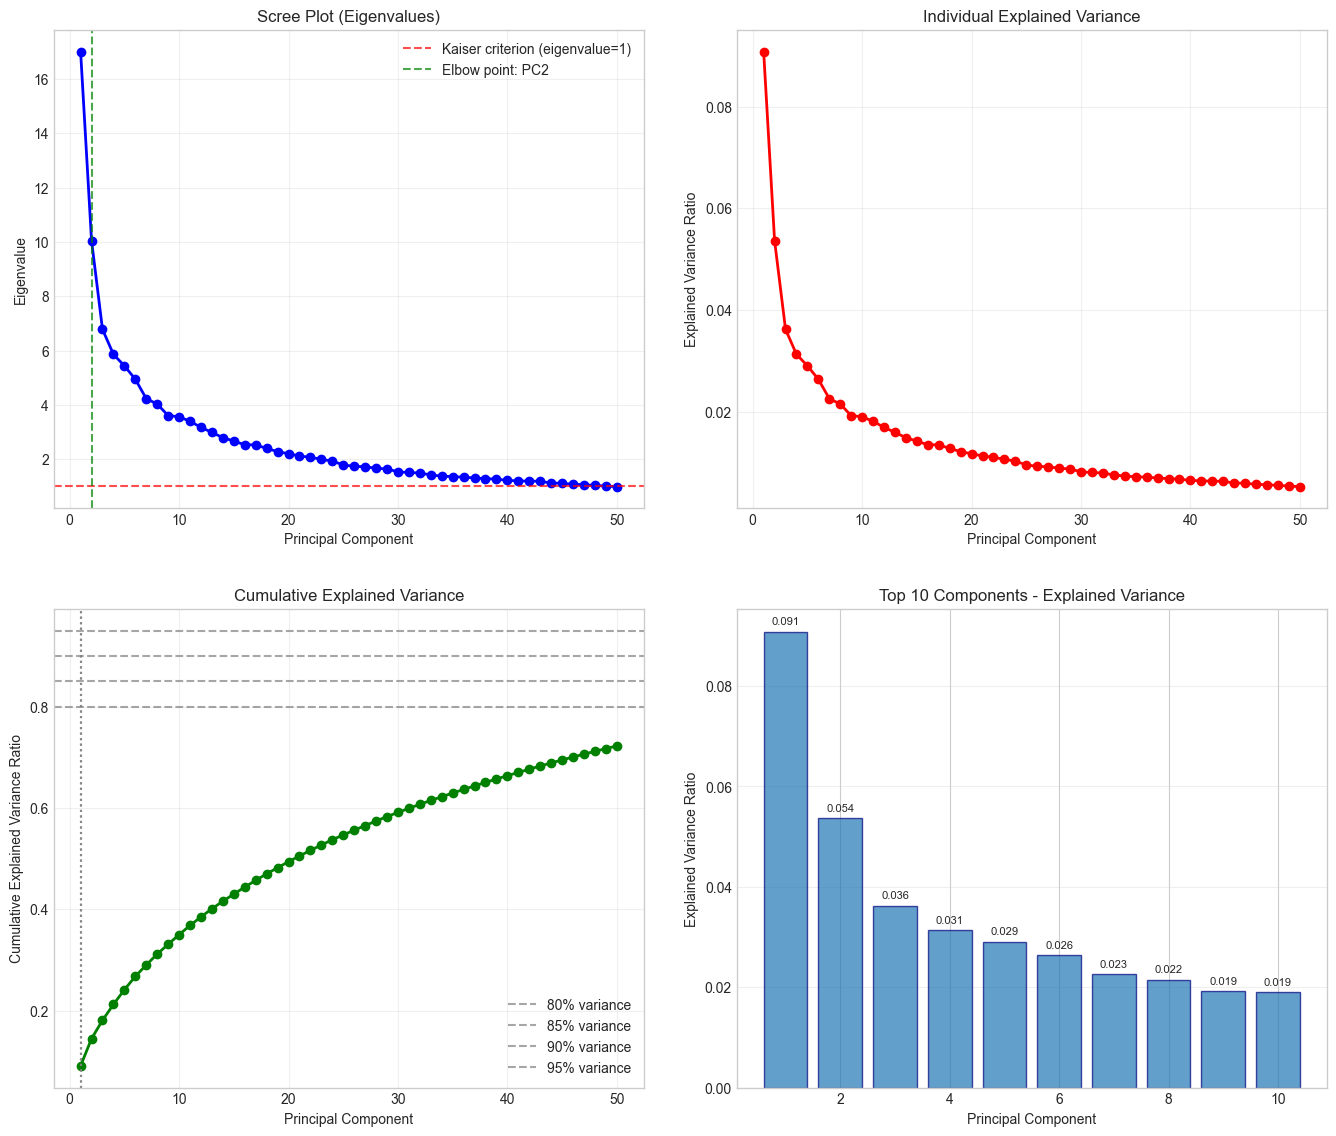


PCA Analysis Summary
Total features analyzed: 187
Samples used for PCA: 770

Recommended number of components based on different criteria:
- Kaiser Criterion (Eigenvalue≥1): 49 components
- 80% Variance Threshold: 1 components
- 90% Variance Threshold: 1 components

--- Step 3: Applying PCA for Dimensionality Reduction ---
Running PCA on 770 complete samples.
✅ PCA completed. Generated 10 PCs explaining 35.0% of variance.

🎉 FULL PIPELINE EXECUTION COMPLETE! 🎉

--- Final DataFrame Head (showing relevant columns) ---
    patno  site        age  sex   MRI_PC1   MRI_PC2   MRI_PC3   MRI_PC4  \
0    3001    10  65.142466    1  1.785035  0.457087  1.060252  0.873466   
12   3002    10  67.578082    0  0.119079  2.572068  2.167249 -1.333626   
22   3003    10  56.717808    0  1.686325 -0.238623  3.252898  2.241691   
34   3006    10  57.539726    0  4.294364  0.520667 -1.438806 -1.099331   
36   3007    10  64.547945    1 -1.236812  2.041425  0.271455  1.589886   

     MRI_PC5   MRI_PC6   M

In [61]:
# -*- coding: utf-8 -*-
"""
Main Pipeline Script

This script orchestrates the entire MRI preprocessing workflow by importing and
calling functions from the modularized scripts:
1. residualisation.py
2. combat_harmonization.py
3. pca_analysis.py

This structure ensures a clear, sequential, and reproducible data processing flow.
"""
import pandas as pd
import numpy as np

# =========================
# Main Execution
# =========================
def run_full_mri_pipeline(raw_df, mri_feature_cols, meta_cols, optimal_n_components=10):
    """
    Orchestrates the full pipeline from raw data to PCA features.
    """
    print("🚀 STARTING FULL MRI FEATURE PROCESSING PIPELINE 🚀")
    print("=" * 60)
    
    # --- Step 1: Residualisation for Scaling Correction ---
    df_after_res, residualised_features = apply_brain_corrections(raw_df, mri_feature_cols)
    if not residualised_features:
        print("❌ Pipeline halted at Step 1: No features survived residualisation.")
        return None, {}

    # --- Step 2: ComBat for Technical Harmonization ---
    df_after_combat, harmonized_features = apply_combat(
        df=df_after_res,
        feature_cols=residualised_features,
        meta_cols=meta_cols
    )
    if not harmonized_features:
        print("❌ Pipeline halted at Step 2: No features survived harmonization.")
        return None, {}
    
    print(len(harmonized_features))

    # --- Step 3 (Optional but Recommended): Diagnostic PCA Plots ---
    # This helps in visually confirming the choice of optimal_n_components
    analyze_pca_with_plots(df_after_combat, harmonized_features)
    
    # --- Step 4: Final PCA for Dimensionality Reduction ---
    final_df, pca_features = apply_pca(
        df=df_after_combat,
        feature_cols=harmonized_features,
        optimal_n_components=optimal_n_components
    )
    
    print("\n🎉 FULL PIPELINE EXECUTION COMPLETE! 🎉")
    
    results = {
        "final_df": final_df,
        "residualised_features": residualised_features,
        "harmonized_features": harmonized_features,
        "pca_features": pca_features
    }
    return final_df, results

# =========================
# Example Usage
# =========================
if __name__ == '__main__':
    print(f"Total MRI features to process: {len(mri_feature_cols)}")
    meta_cols = ('site', 'age', 'sex')

    # --- Execute the full, modular pipeline ---
    final_processed_df, results_dict = run_full_mri_pipeline(
        raw_df=mri_combined_df,
        mri_feature_cols=mri_feature_cols,
        meta_cols=meta_cols,
        optimal_n_components=10
    )

    if final_processed_df is not None:
        print("\n--- Final DataFrame Head (showing relevant columns) ---")
        display_cols = ['patno'] + list(meta_cols) + results_dict.get("pca_features", [])
        # Ensure columns exist before displaying
        display_cols = [c for c in display_cols if c in final_processed_df.columns]
        print(final_processed_df[display_cols].head())
        print(f"\nFinal shape: {final_processed_df.shape}")


In [ ]:
def diagnose_feature_loss(df, mri_feature_cols):
    print("🔍 DIAGNOSING FEATURE LOSS")
    print("=" * 60)
    print(f"Initial MRI features: {len(mri_feature_cols)}")
    cols = df.columns
    
    thickness_cols = []
    for c in cols:
        if any(k in c.lower() for k in ['_cth', 'thick']) or c in ['lh_meanthickness', 'rh_meanthickness']:
            thickness_cols.append(c)
    
    area_cols = []
    for c in cols:
        if c not in thickness_cols:
            if (any(k in c.lower() for k in ['_sa', 'surfarea', '_area']) or 
                c in ['lh_whitesurfarea', 'rh_whitesurfarea']) and \
               not c.endswith('_to_etiv'):
                area_cols.append(c)
    
    vol_cols = []
    for c in cols:
        if c not in thickness_cols and c not in area_cols:
            if ('vol' in c.lower()) or \
               any(k in c.lower() for k in [
                   'thalamus','caudate','putamen','pallidum','amygdala',
                   'hippocampus','accumbens','ventricle','ventraldc',
                   'choroid_plexus','brain_stem','cortexvol','totalgrayvol',
                   'cerebellum','whitematter','wm_hypointensities','non_wm_hypointensities',
                   'corpuscallosum','cc_','optic_chiasm'
               ]):
                if not c.endswith('_to_etiv'):
                    vol_cols.append(c)
    
    classified_features = thickness_cols + area_cols + vol_cols
    unclassified_features = [f for f in mri_feature_cols if f not in classified_features]
    
    print(f"Thickness features: {len(thickness_cols)}")
    print(f"Surface area features: {len(area_cols)}")
    print(f"Volume features: {len(vol_cols)}")
    print(f"Total classified: {len(classified_features)}")
    print(f"Unclassified features: {len(unclassified_features)}")
    
    if unclassified_features:
        print(f"\n❌ UNCLASSIFIED FEATURES ({len(unclassified_features)}):")
        for i, feature in enumerate(unclassified_features[:20]): 
            print(f"  {i+1:2d}. {feature}")
        if len(unclassified_features) > 20:
            print(f"  ... and {len(unclassified_features)-20} more")
    
    etiv = next((c for c in ['estimatedtotalintracranialvol', 'etiv', 'totalintracranialvol'] if c in df.columns), None)
    mean_cth_cols = [c for c in ['lh_meanthickness', 'rh_meanthickness'] if c in df.columns]
    
    print(f"\n📊 AVAILABLE COVARIATES:")
    print(f"eTIV column: {etiv}")
    print(f"Mean thickness columns: {mean_cth_cols}")
    
    print(f"\n📉 MISSING VALUES:")
    missing_summary = df[mri_feature_cols].isnull().sum().sort_values(ascending=False)
    high_missing = missing_summary[missing_summary > len(df) * 0.1]  # >10% missing
    print(f"Features with >10% missing: {len(high_missing)}")
    
    if len(high_missing) > 0:
        print("Top 10 features with highest missing rates:")
        for feature, missing_count in high_missing.head(10).items():
            missing_rate = missing_count / len(df) * 100
            print(f"  {feature}: {missing_rate:.1f}% ({missing_count}/{len(df)})")
    
    return {
        'thickness_cols': thickness_cols,
        'area_cols': area_cols, 
        'vol_cols': vol_cols,
        'unclassified': unclassified_features,
        'high_missing': high_missing
    }
diagnosis = diagnose_feature_loss(mri_combined_df, mri_feature_cols)

🔍 DIAGNOSING FEATURE LOSS
Initial MRI features: 204
Thickness features: 70
Surface area features: 72
Volume features: 52
Total classified: 194
Unclassified features: 10

❌ UNCLASSIFIED FEATURES (10):
   1. left_vessel
   2. maskvol_to_etiv
   3. right_inf_lat_vent
   4. brainsegvol_to_etiv
   5. left_inf_lat_vent
   6. right_vessel
   7. lhsurfaceholes
   8. rhsurfaceholes
   9. csf
  10. surfaceholes

📊 AVAILABLE COVARIATES:
eTIV column: estimatedtotalintracranialvol
Mean thickness columns: ['lh_meanthickness', 'rh_meanthickness']

📉 MISSING VALUES:
Features with >10% missing: 0


In [ ]:
# -*- coding: utf-8 -*-
"""
Verification (Aligned with Main Pipeline)

This script is fully aligned with the main pipeline, reusing and outputting all metrics from evaluate_harmonization,
and additionally exporting per-feature R²(site), ANOVA results, and PCA dimension R²(site) diagnostics.

Dependencies: The following functions must exist in the current session/namespace:
- r2_site_per_feature, anova_by_site, site_predictability_score, age_sex_preservation, evaluate_harmonization

Input: Assumes you have run the main pipeline and obtained final_processed_df and results_dict
Output: CSV files saved in ./harm_eval_outputs_aligned
"""

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from pathlib import Path
import patsy
from collections import Counter
from sklearn.base import clone

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score

# ========= Configuration =========
OUTDIR = Path("harm_eval_outputs_aligned")
OUTDIR.mkdir(parents=True, exist_ok=True)

ID_COL   = "patno"
SITE_COL = "site"
AGE_COL  = "age"
SEX_COL  = "sex"

# Consistent with main pipeline: classification metrics use only accuracy (mean±std) and majority baseline
# Number of principal components for PCA diagnostics (for reference, consistent with main pipeline visualization)
N_PCS = 10
RANDOM_STATE = 42


# ========= Utility Functions =========
def design_mats(df, y_col, covars, site_col=None):
    """Generate design matrix with patsy: y ~ covars (+ C(site))"""
    cov_term = " + ".join(covars) if covars else "1"
    if site_col is None:
        formula = f"{y_col} ~ {cov_term}"
    else:
        formula = f"{y_col} ~ {cov_term} + C({site_col})"
    y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    return y.iloc[:, 0], X

def incr_r2_site(df, feature, covars, site_col):
    """Calculate incremental R²(site) for a single feature, controlling for covars."""
    sub = df[[feature, site_col] + covars].dropna()
    if sub.shape[0] < 50:
        return np.nan, np.nan, np.nan, sub.shape[0]
    y_base, X_base = design_mats(sub, feature, covars, site_col=None)
    y_full, X_full = design_mats(sub, feature, covars, site_col=site_col)
    try:
        m0 = sm.OLS(y_base, X_base).fit()
        m1 = sm.OLS(y_full, X_full.loc[y_base.index]).fit()
        dR2 = m1.rsquared - m0.rsquared
        return dR2, m0.rsquared, m1.rsquared, sub.shape[0]
    except Exception:
        return np.nan, np.nan, np.nan, sub.shape[0]

def block_delta_r2(df, feature_cols, label):
    """Calculate incremental R²(site) for a batch of features and output CSV."""
    rows = []
    for f in feature_cols:
        dR2, r2b, r2f, n = incr_r2_site(df, f, COVARS, SITE_COL)
        rows.append({"feature": f, "n": n, "R2_base": r2b, "R2_full": r2f, "deltaR2_site": dR2})
    out = pd.DataFrame(rows).sort_values("deltaR2_site", ascending=False)
    out.to_csv(OUTDIR / f"deltaR2_site_{label}.csv", index=False)
    summ = {
        "label": label,
        "k_features": len(out),
        "n_median": float(out["n"].median()),
        "deltaR2_site_median": float(out["deltaR2_site"].median()),
        "deltaR2_site_95pct": float(out["deltaR2_site"].quantile(0.95)),
        "frac_deltaR2>0.05": float((out["deltaR2_site"] > 0.05).mean()),
    }
    pd.DataFrame([summ]).to_csv(OUTDIR / f"deltaR2_site_{label}_summary.csv", index=False)
    print(f"[{label}] median ΔR²(site)={summ['deltaR2_site_median']:.3f}, 95pct={summ['deltaR2_site_95pct']:.3f}, frac>0.05={summ['frac_deltaR2>0.05']:.2f}")
    return out

def pca_delta_r2(df, feature_cols, label, n_pcs=N_PCS):
    """Standardize + PCA, then calculate ΔR²(site) for PC1..PCk."""
    sub = df[feature_cols + [SITE_COL] + COVARS].dropna()
    if sub.shape[0] < 50:
        raise ValueError("Too few samples")
    X = sub[feature_cols].values
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_pcs, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    pc_cols = [f"PC{i+1}" for i in range(n_pcs)]
    pc_df = pd.DataFrame(Z, columns=pc_cols, index=sub.index)
    pc_df = pd.concat([pc_df, sub[[SITE_COL] + COVARS]], axis=1)

    rows = []
    for pc in pc_cols:
        dR2, r2b, r2f, n = incr_r2_site(pc_df, pc, COVARS, SITE_COL)
        rows.append({"feature": pc, "n": n, "R2_base": r2b, "R2_full": r2f, "deltaR2_site": dR2})
    out = pd.DataFrame(rows).sort_values("deltaR2_site", ascending=False)
    out.to_csv(OUTDIR / f"deltaR2_site_{label}_PCA.csv", index=False)

    # Record explained variance
    ve = pd.DataFrame({"component": pc_cols, "explained_variance_ratio": pca.explained_variance_ratio_})
    ve.to_csv(OUTDIR / f"pca_variance_{label}.csv", index=False)

    summ = {
        "label": f"{label}_PCA",
        "k_features": len(out),
        "n_median": float(out["n"].median()),
        "deltaR2_site_median": float(out["deltaR2_site"].median()),
        "deltaR2_site_95pct": float(out["deltaR2_site"].quantile(0.95)),
        "frac_deltaR2>0.05": float((out["deltaR2_site"] > 0.05).mean()),
        "cum_var_ratio_PCk": float(pca.explained_variance_ratio_.sum())
    }
    pd.DataFrame([summ]).to_csv(OUTDIR / f"deltaR2_site_{label}_PCA_summary.csv", index=False)
    print(f"[{label} PCA] median ΔR²(site)={summ['deltaR2_site_median']:.3f}, 95pct={summ['deltaR2_site_95pct']:.3f}, frac>0.05={summ['frac_deltaR2>0.05']:.2f}, cum_var={summ['cum_var_ratio_PCk']:.2f}")
    return out, ve

def safe_macro_f1(y_true, y_pred):
    # Calculate macro-F1 only on classes present in test fold to avoid errors
    labels = np.unique(y_true)
    return f1_score(y_true, y_pred, average="macro", labels=labels, zero_division=0)

def cv_site_classify(df, feature_cols, label, min_n_per_site=8):
    """
    More robust site predictability assessment:
    - Filter out sites with too few samples (default >=8)
    - Use safe_macro_f1 for each fold to avoid missing class errors
    - Return balanced accuracy and macro-F1
    """
    # 1) Filter missing
    sub = df[feature_cols + [SITE_COL]].dropna()
    X_all = sub[feature_cols].values
    y_all = sub[SITE_COL].astype(str).values

    # 2) Filter small sites
    cnt = Counter(y_all)
    keep_mask = np.array([cnt[c] >= min_n_per_site for c in y_all])
    X = X_all[keep_mask]
    y = y_all[keep_mask]

    # If too few classes or samples, skip CV
    if len(np.unique(y)) < 2 or len(y) < 3:
        print(f"[{label}] too few samples/classes after filtering; skip CV")
        res = pd.DataFrame({
            "label":[label],
            "n":[len(y)],
            "n_sites":[len(np.unique(y))],
            "balanced_acc_mean":[np.nan],
            "balanced_acc_std":[np.nan],
            "macro_f1_mean":[np.nan],
            "macro_f1_std":[np.nan],
        })
        res.to_csv(OUTDIR / f"site_cv_{label}_logreg.csv", index=False)
        return res

    # 3) Pipeline (avoid explicit multi_class to prevent FutureWarning)
    base_clf = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
    clf = make_pipeline(StandardScaler(), base_clf)

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    bal_scores, f1_scores = [], []
    for train_idx, test_idx in skf.split(X, y):
        model = clone(clf)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        bal_scores.append(balanced_accuracy_score(y[test_idx], y_pred))
        f1_scores.append(safe_macro_f1(y[test_idx], y_pred))

    res = pd.DataFrame({
        "label":[label],
        "n":[len(y)],
        "n_sites":[len(np.unique(y))],
        "balanced_acc_mean":[float(np.mean(bal_scores))],
        "balanced_acc_std":[float(np.std(bal_scores))],
        "macro_f1_mean":[float(np.mean(f1_scores))],
        "macro_f1_std":[float(np.std(f1_scores))],
    })
    res.to_csv(OUTDIR / f"site_cv_{label}_logreg.csv", index=False)
    print(f"[{label}] sites={res['n_sites'].iloc[0]}, n={res['n'].iloc[0]}, "
          f"balanced_acc={res['balanced_acc_mean'].iloc[0]:.3f}±{res['balanced_acc_std'].iloc[0]:.3f}, "
          f"macroF1={res['macro_f1_mean'].iloc[0]:.3f}±{res['macro_f1_std'].iloc[0]:.3f}")


# ========= Utility Functions =========
def _safe_series_to_csv(series: pd.Series, path: Path, name: str):
    df = series.rename(name).to_frame()
    df.to_csv(path, index=True)

def _export_eval_series(eval_out: dict, prefix: str):
    """Export Series returned by evaluate_harmonization."""
    if eval_out.get("r2_site_pre") is not None:
        _safe_series_to_csv(eval_out["r2_site_pre"], OUTDIR / f"{prefix}_r2_site_pre.csv", "r2_site")
    if eval_out.get("r2_site_post") is not None:
        _safe_series_to_csv(eval_out["r2_site_post"], OUTDIR / f"{prefix}_r2_site_post.csv", "r2_site")

    if eval_out.get("anova_p_pre") is not None:
        _safe_series_to_csv(eval_out["anova_p_pre"], OUTDIR / f"{prefix}_anova_p_pre.csv", "p_value")
    if eval_out.get("anova_q_pre") is not None:
        _safe_series_to_csv(eval_out["anova_q_pre"], OUTDIR / f"{prefix}_anova_q_pre.csv", "q_value")
    if eval_out.get("anova_sig_pre") is not None:
        _safe_series_to_csv(eval_out["anova_sig_pre"].astype(int), OUTDIR / f"{prefix}_anova_sig_pre.csv", "sig_FDR<0.05")

    if eval_out.get("anova_p_post") is not None:
        _safe_series_to_csv(eval_out["anova_p_post"], OUTDIR / f"{prefix}_anova_p_post.csv", "p_value")
    if eval_out.get("anova_q_post") is not None:
        _safe_series_to_csv(eval_out["anova_q_post"], OUTDIR / f"{prefix}_anova_q_post.csv", "q_value")
    if eval_out.get("anova_sig_post") is not None:
        _safe_series_to_csv(eval_out["anova_sig_post"].astype(int), OUTDIR / f"{prefix}_anova_sig_post.csv", "sig_FDR<0.05")

def _summary_to_csv(summary: dict, path: Path):
    pd.DataFrame([summary]).to_csv(path, index=False)

def _pca_r2_site(df: pd.DataFrame, feature_cols: list, n_pcs: int, label: str):
    """
    Consistent with main pipeline: For PCA-derived PC1..PCk, calculate R²(site) for each PC (explained by site only).
    Note: Does not control for age/sex, matching main pipeline r2_site_per_feature.
    """
    sub = df[feature_cols + [SITE_COL]].dropna()
    if sub.shape[0] < max(50, n_pcs + 5):
        print(f"[{label}] Too few samples ({sub.shape[0]}), skipping PCA diagnostics.")
        return None, None

    X = sub[feature_cols].astype(float).values
    X = StandardScaler().fit_transform(X)

    k = min(n_pcs, sub.shape[0] - 1, len(feature_cols))
    pca = PCA(n_components=k, random_state=RANDOM_STATE)
    Z = pca.fit_transform(X)
    pc_cols = [f"{label}_PC{i+1}" for i in range(k)]
    pc_df = pd.DataFrame(Z, columns=pc_cols, index=sub.index)

    # Calculate R²(site) for each PC
    r2_pc = r2_site_per_feature(pc_df, sub[SITE_COL])
    _safe_series_to_csv(r2_pc, OUTDIR / f"pca_r2_site_{label}.csv", "r2_site")
    ve = pd.DataFrame({"component": pc_cols, "explained_variance_ratio": pca.explained_variance_ratio_})
    ve.to_csv(OUTDIR / f"pca_variance_{label}.csv", index=False)

    # Brief summary
    summ = {
        "label": label,
        "n_samples": int(sub.shape[0]),
        "k_components": int(k),
        "r2_site_median": float(r2_pc.median()) if len(r2_pc) else np.nan,
        "r2_site_q90": float(r2_pc.quantile(0.9)) if len(r2_pc) else np.nan,
        "cum_var_ratio_PCk": float(pca.explained_variance_ratio_.sum()),
        "r2_site_gt_0p1_count": int((r2_pc > 0.10).sum()) if len(r2_pc) else 0,   # New: number of PCs with R²>0.10
    }

    _summary_to_csv(summ, OUTDIR / f"pca_r2_site_{label}_summary.csv")
    print(f"[{label} PCA] median R²(site)={summ['r2_site_median']:.3f}, "
      f"q90={summ['r2_site_q90']:.3f}, cum_var={summ['cum_var_ratio_PCk']:.2f}, "
      f"PCs with R²>0.10={summ['r2_site_gt_0p1_count']}")
    return r2_pc, ve


# ========= Main Pipeline (Aligned Verification) =========
if __name__ == "__main__":
    # Expect you have run the main pipeline and have:
    # - final_processed_df: contains res_* and h_* (if ComBat fails, h_* mirrors res_*)
    # - results_dict: contains "harmonized_features" (list of h_* column names)
    df = final_processed_df.copy()

    # Basic checks
    needed_cols = [SITE_COL, AGE_COL, SEX_COL]
    for c in needed_cols:
        if c not in df.columns:
            raise ValueError(f"Missing required column: {c}")

    # Identify columns
    h_cols_all   = [c for c in df.columns if c.startswith("h_")]
    res_cols_all = [c for c in df.columns if c.startswith("res_")]
    if len(h_cols_all) == 0 and "harmonized_features" in results_dict:
        h_cols_all = list(results_dict["harmonized_features"])

    assert len(h_cols_all) > 0, "No h_* (ComBat/post-mirror) feature columns found."
    # Map h_* back to corresponding residual column names (by main pipeline convention: h_ + original residual name)
    base_res_names = [c[2:] for c in h_cols_all]  # Remove 'h_' prefix
    # Only keep residual columns that actually exist in df
    base_res_names = [c for c in base_res_names if c in df.columns]
    # Features for joint evaluation (based on h_ columns)
    feature_cols_eval = [f"h_{c}" for c in base_res_names]

    # Build pre/post views, consistent with main pipeline evaluate_harmonization usage:
    # pre: site/age/sex + residual (renamed to h_*)
    # post: site/age/sex + h_* (ComBat output or mirror)
    pre_eval = df[[SITE_COL, AGE_COL, SEX_COL] + base_res_names].dropna().copy()
    pre_eval.rename(columns={c: f"h_{c}" for c in base_res_names}, inplace=True)

    post_eval = df[[SITE_COL, AGE_COL, SEX_COL] + feature_cols_eval].dropna().copy()

    # Align sample indices (both complete)
    common_idx = pre_eval.index.intersection(post_eval.index)
    pre_eval  = pre_eval.loc[common_idx]
    post_eval = post_eval.loc[common_idx]

    # ---- 1) Comprehensive evaluation fully consistent with main pipeline ----
    eval_out = evaluate_harmonization(
        df_pre = pre_eval,
        df_post = post_eval,
        feature_cols = feature_cols_eval,
        site_col = SITE_COL,
        age_col = AGE_COL,
        sex_col = SEX_COL,
        verbose = True
    )

    # === [Counts] ===
    counts = {
        "n_features_eval": len(feature_cols_eval),                    # Number of features evaluated (h_*)
        "n_samples_eval": len(common_idx),                            # Number of samples used for evaluation (pre/post complete)
        "n_sites_eval": int(pre_eval[SITE_COL].nunique()),            # Number of sites
        "anova_sig_count_pre": int(eval_out["anova_sig_pre"].sum()) if "anova_sig_pre" in eval_out else 0,
        "anova_sig_count_post": int(eval_out["anova_sig_post"].sum()) if "anova_sig_post" in eval_out else 0,
        "r2_site_gt_0p1_pre": int((eval_out["r2_site_pre"] > 0.10).sum()) if "r2_site_pre" in eval_out else 0,
        "r2_site_gt_0p1_post": int((eval_out["r2_site_post"] > 0.10).sum()) if "r2_site_post" in eval_out else 0,
    }
    pd.DataFrame([counts]).to_csv(OUTDIR / "counts_basic.csv", index=False)

    # Optional: sample count distribution per site
    site_counts = pre_eval[SITE_COL].value_counts().sort_index()
    site_counts.to_csv(OUTDIR / "counts_per_site.csv", header=["n_samples"])
    print(f"Counts — features={counts['n_features_eval']}, samples={counts['n_samples_eval']}, sites={counts['n_sites_eval']}, "
        f"ANOVA sig(pre→post)={counts['anova_sig_count_pre']}→{counts['anova_sig_count_post']}, "
        f"R²>0.10(pre→post)={counts['r2_site_gt_0p1_pre']}→{counts['r2_site_gt_0p1_post']}")
    
    # Export summary and details
    _summary_to_csv(eval_out["summary"], OUTDIR / "summary_overall.csv")
    _export_eval_series(eval_out, prefix="roi_level")

    # ---- 2) PCA dimension diagnostics (pre/post spaces; consistent with main pipeline) ----
    _ = _pca_r2_site(pre_eval,  feature_cols_eval, N_PCS, label="PRE")
    _ = _pca_r2_site(post_eval, feature_cols_eval, N_PCS, label="POST")

    # ---- 3) Additional export: site classification accuracy (consistent with main pipeline) ----
    # Note: evaluate_harmonization already prints and returns accuracy (mean±std) and majority baseline
    # Here, save as CSV for documentation
    cls_row = {
        "acc_mean_pre":  eval_out["summary"]["site_cls_acc_pre"],
        "acc_std_pre":   eval_out["summary"]["site_cls_acc_std_pre"],
        "acc_mean_post": eval_out["summary"]["site_cls_acc_post"],
        "acc_std_post":  eval_out["summary"]["site_cls_acc_std_post"],
        "majority_baseline": eval_out["summary"]["majority_baseline"]
    }
    pd.DataFrame([cls_row]).to_csv(OUTDIR / "site_cls_accuracy.csv", index=False)

    print(f"\n✔ Aligned verification complete. Outputs located at: {OUTDIR.resolve()}\n")



=== Harmonization Evaluation ===
R²_site median:  pre=0.124  → post=0.012
R²_site 90th %:  pre=0.209  → post=0.029
ANOVA (FDR<0.05) proportion: pre=0.845  → post=0.000
Site classification acc (CV): pre=0.275  → post=0.001
Majority-class baseline: 0.156
Age/Sex R² median: pre=0.009 → post=0.011
ΔR² (median): 0.002  |  Δcoef L2 (median): 0.002

Verdict: PASS  (R²:True, ANOVA:True, Cls:True)
Counts — features=187, samples=770, sites=43, ANOVA sig(pre→post)=158→0, R²>0.10(pre→post)=133→0
[PRE PCA] median R²(site)=0.151, q90=0.268, cum_var=0.39, PCs with R²>0.10=10
[POST PCA] median R²(site)=0.013, q90=0.034, cum_var=0.35, PCs with R²>0.10=0

✔ 对齐版验证完成。输出位于：D:\ZLifeFiles\1_Education\3.UCL\3_Dissertation\Exploring_Multimodal_Data_for_Disease_Progression_Prediction\harm_eval_outputs_aligned



=== PCA LOADINGS MATRIX: ALL FEATURES ===
🎨 Creating PCA Loadings Matrix Visualization...
Found 187 harmonized features and 10 PCA components
Displaying all 187 features, sorted by PC1 correlation


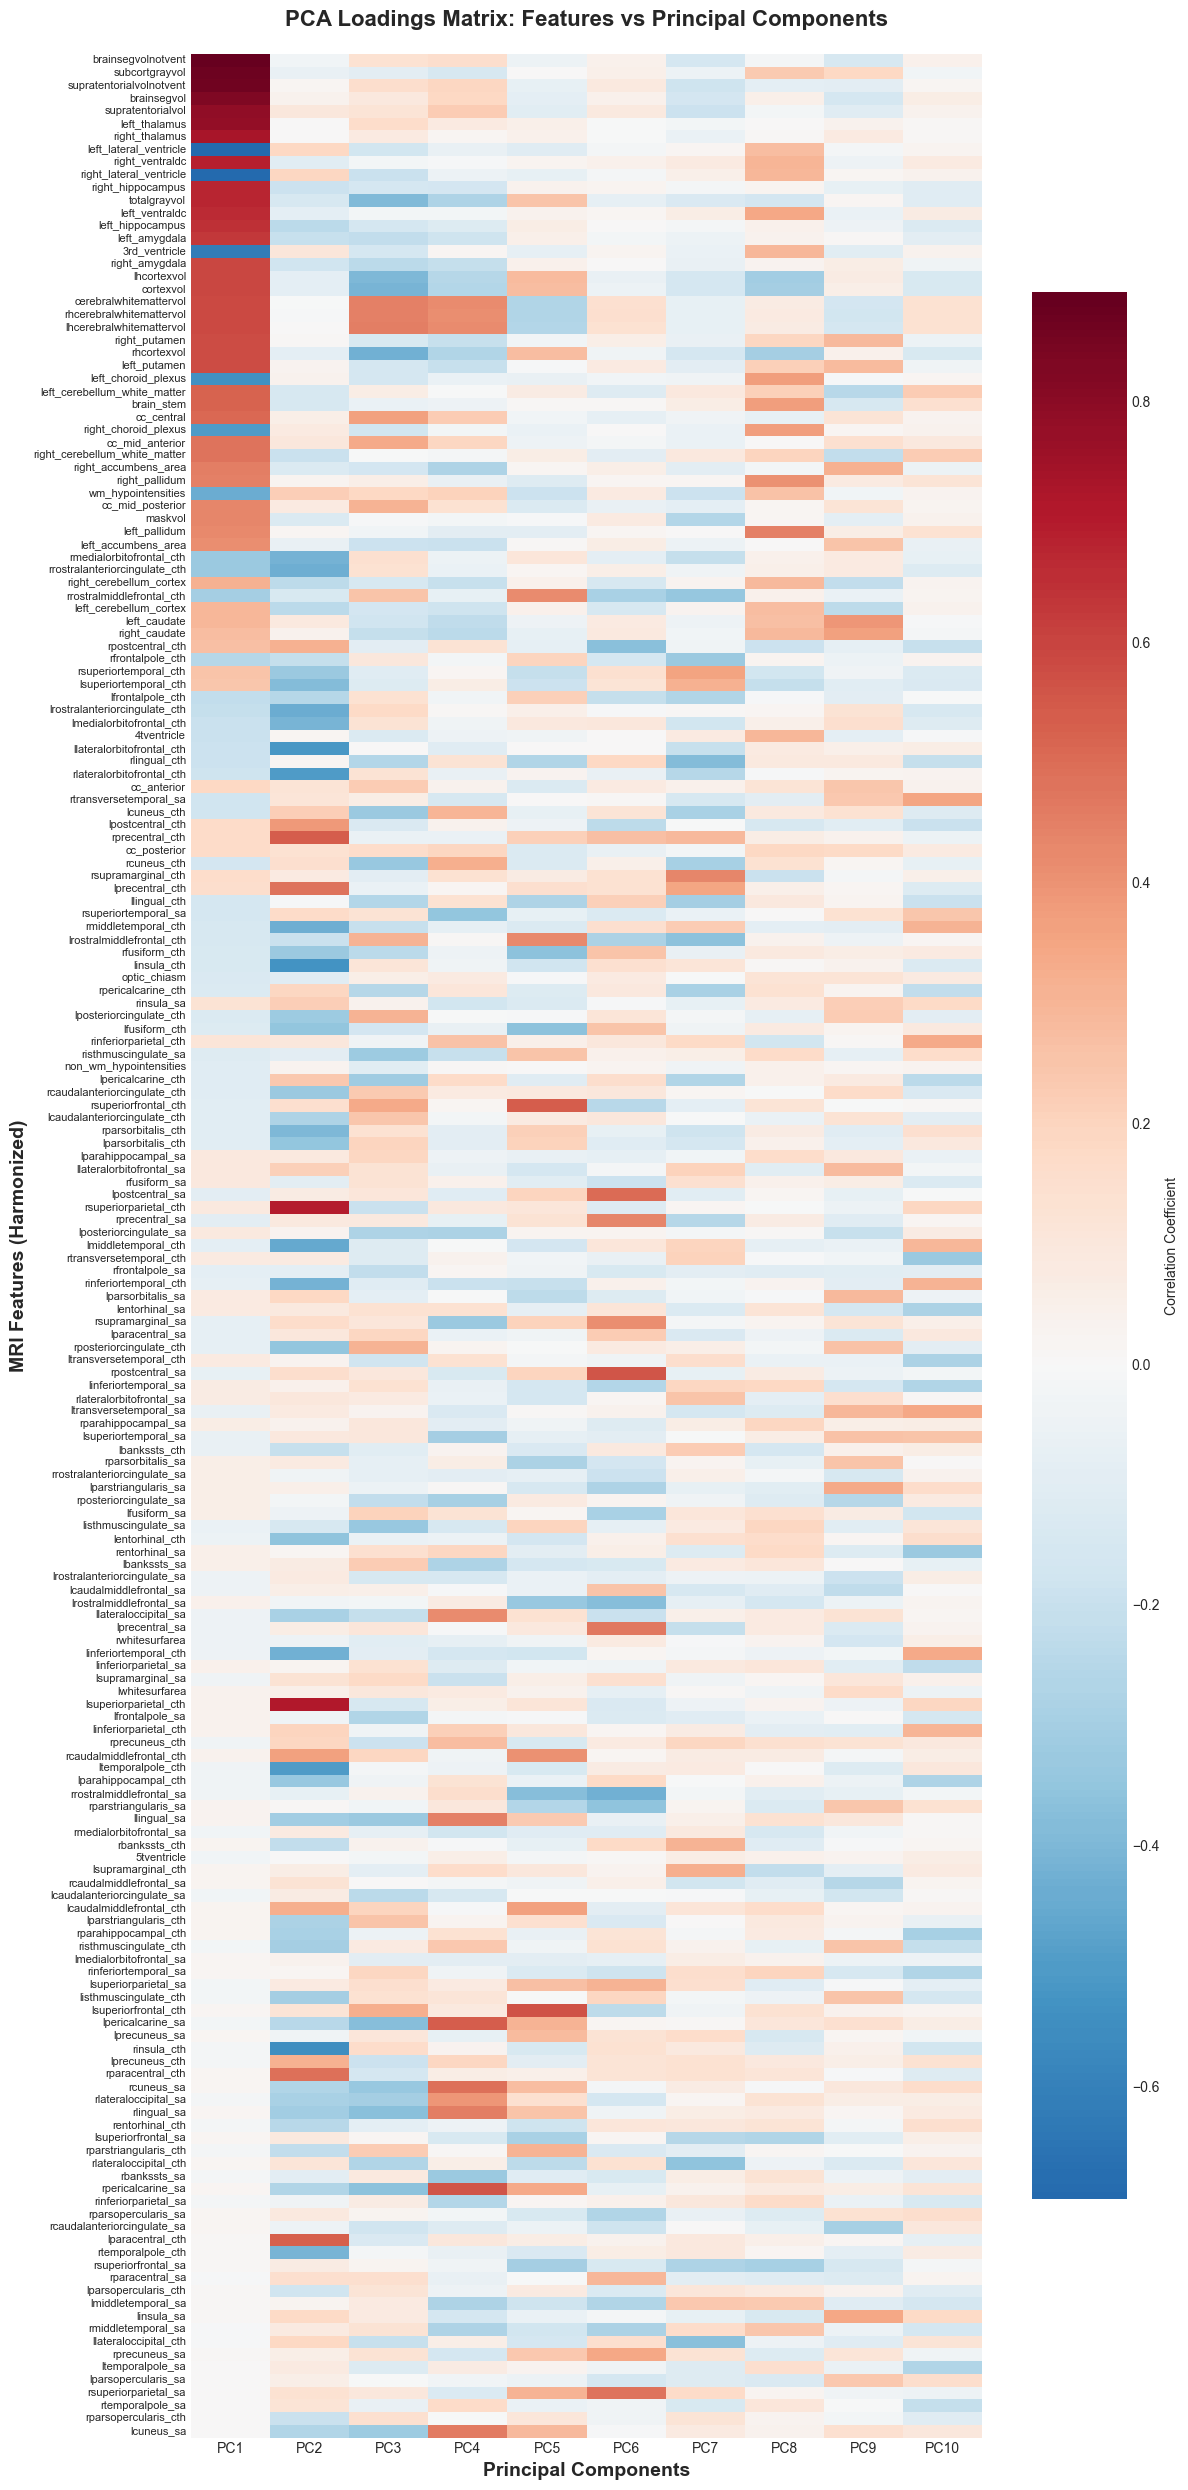


TOP FEATURES FOR EACH PRINCIPAL COMPONENT

🔍 MRI_PC1 - Top 10 Most Important Features:
------------------------------------------------------------
   1. brainsegvolnotvent                  |  0.8908 (+)
   2. subcortgrayvol                      |  0.8693 (+)
   3. supratentorialvolnotvent            |  0.8627 (+)
   4. brainsegvol                         |  0.8341 (+)
   5. supratentorialvol                   |  0.7917 (+)
   6. left_thalamus                       |  0.7814 (+)
   7. right_thalamus                      |  0.7329 (+)
   8. left_lateral_ventricle              |  0.6939 (-)
   9. right_ventraldc                     |  0.6911 (+)
  10. right_lateral_ventricle             |  0.6909 (-)

🔍 MRI_PC2 - Top 10 Most Important Features:
------------------------------------------------------------
   1. lsuperiorparietal_cth               |  0.7084 (+)
   2. rsuperiorparietal_cth               |  0.6940 (+)
   3. rinsula_cth                         |  0.5497 (-)
   4. rprecentral

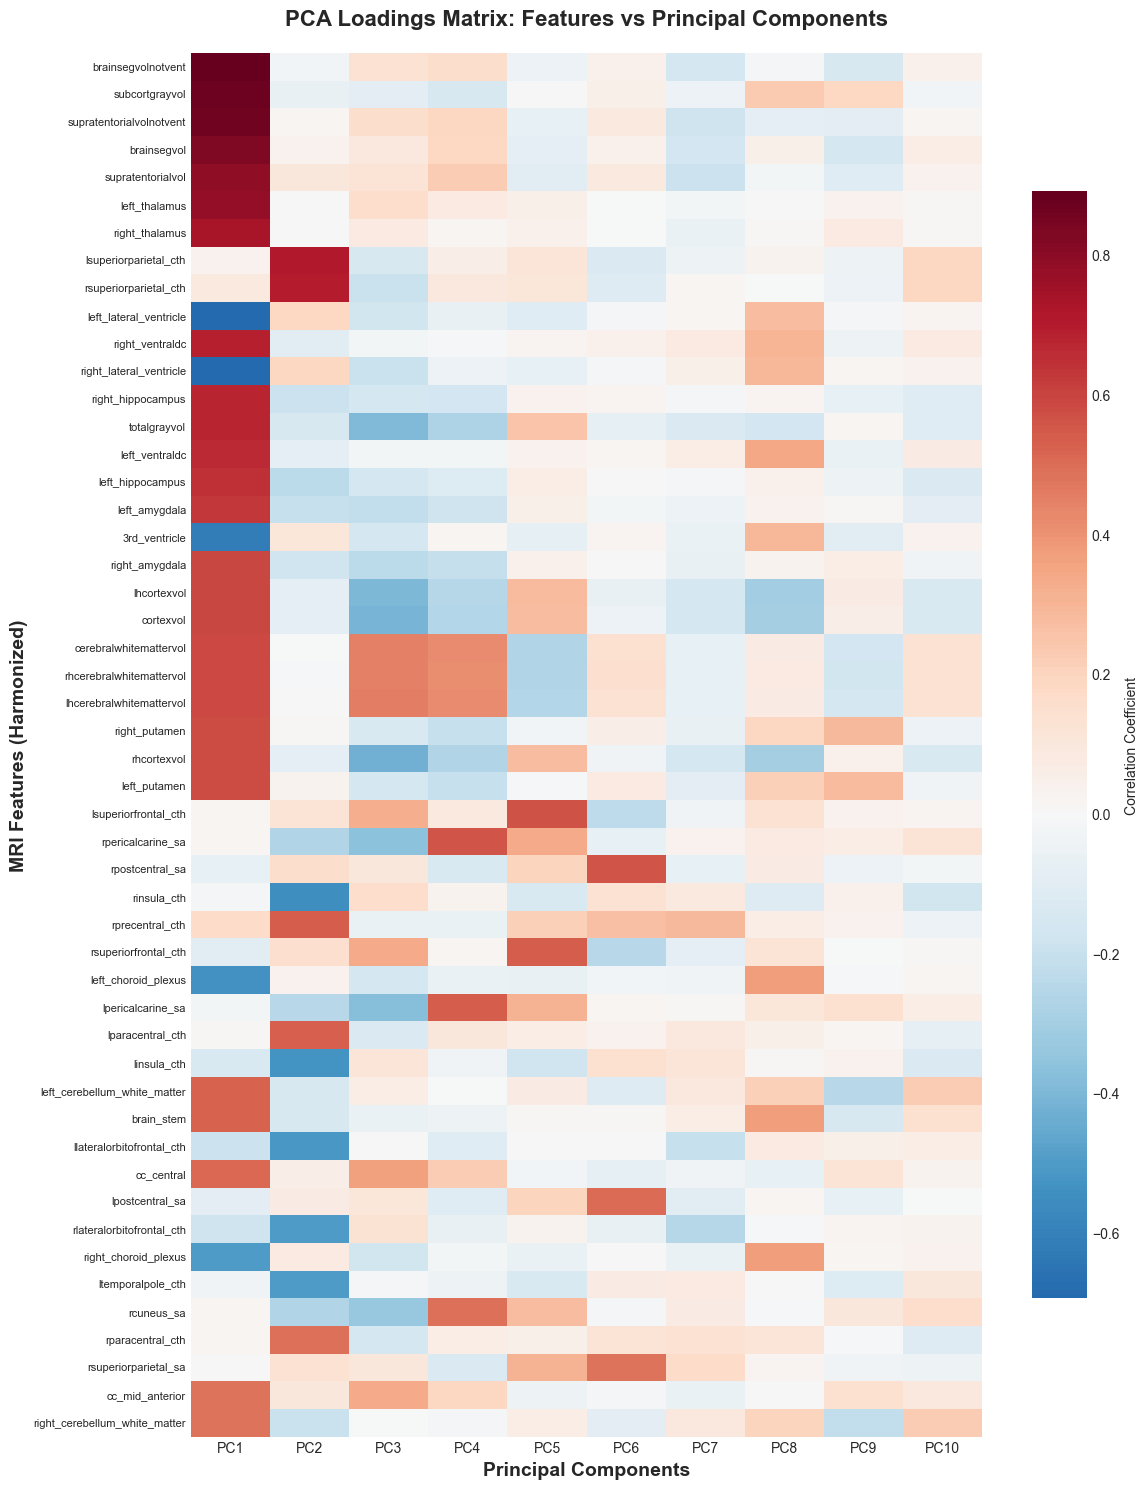


TOP FEATURES FOR EACH PRINCIPAL COMPONENT

🔍 MRI_PC1 - Top 10 Most Important Features:
------------------------------------------------------------
   1. brainsegvolnotvent                  |  0.8908 (+)
   2. subcortgrayvol                      |  0.8693 (+)
   3. supratentorialvolnotvent            |  0.8627 (+)
   4. brainsegvol                         |  0.8341 (+)
   5. supratentorialvol                   |  0.7917 (+)
   6. left_thalamus                       |  0.7814 (+)
   7. right_thalamus                      |  0.7329 (+)
   8. left_lateral_ventricle              |  0.6939 (-)
   9. right_ventraldc                     |  0.6911 (+)
  10. right_lateral_ventricle             |  0.6909 (-)

🔍 MRI_PC2 - Top 10 Most Important Features:
------------------------------------------------------------
   1. lsuperiorparietal_cth               |  0.7084 (+)
   2. rsuperiorparietal_cth               |  0.6940 (+)
   3. rinsula_cth                         |  0.5497 (-)
   4. rprecentral

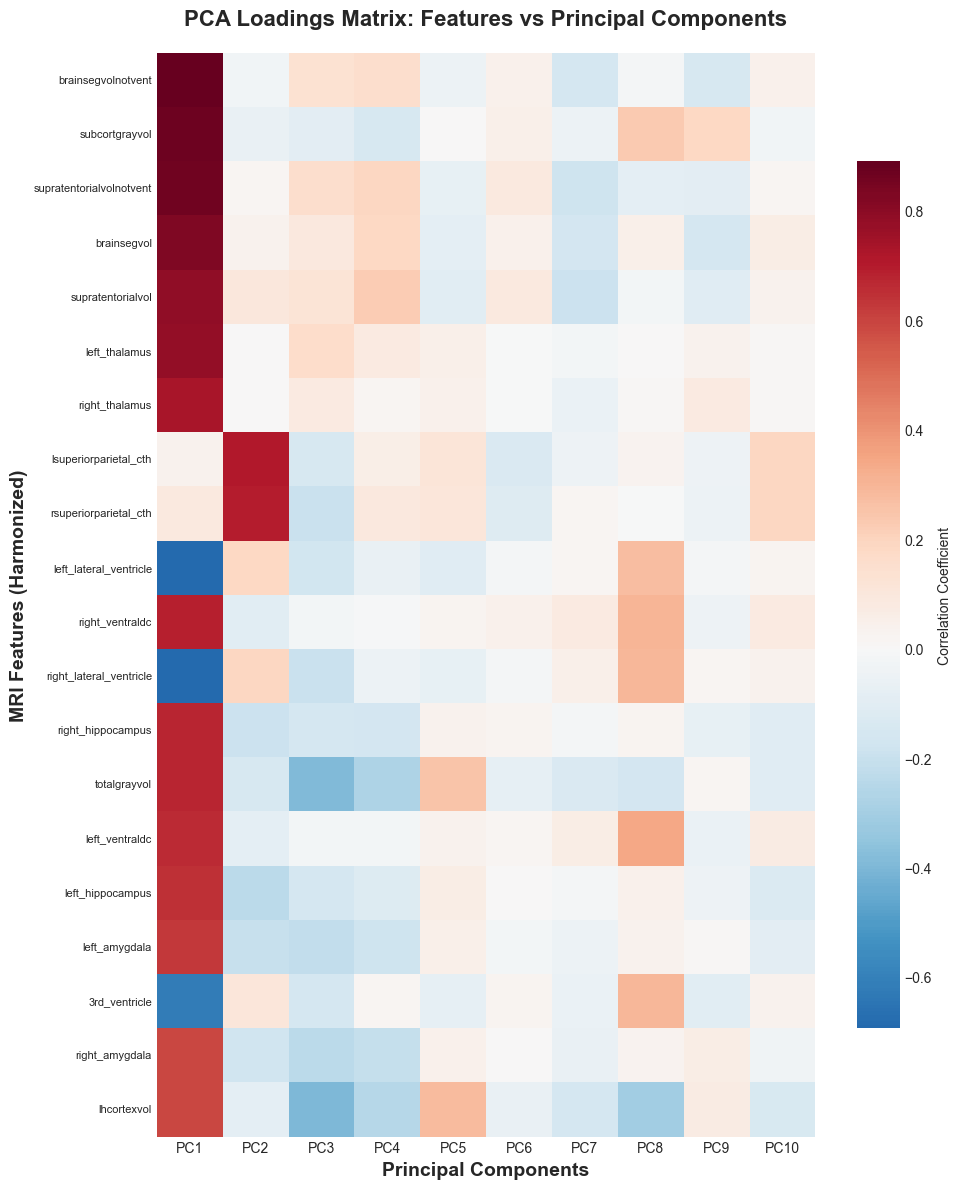


TOP FEATURES FOR EACH PRINCIPAL COMPONENT

🔍 MRI_PC1 - Top 10 Most Important Features:
------------------------------------------------------------
   1. brainsegvolnotvent                  |  0.8908 (+)
   2. subcortgrayvol                      |  0.8693 (+)
   3. supratentorialvolnotvent            |  0.8627 (+)
   4. brainsegvol                         |  0.8341 (+)
   5. supratentorialvol                   |  0.7917 (+)
   6. left_thalamus                       |  0.7814 (+)
   7. right_thalamus                      |  0.7329 (+)
   8. left_lateral_ventricle              |  0.6939 (-)
   9. right_ventraldc                     |  0.6911 (+)
  10. right_lateral_ventricle             |  0.6909 (-)

🔍 MRI_PC2 - Top 10 Most Important Features:
------------------------------------------------------------
   1. lsuperiorparietal_cth               |  0.7084 (+)
   2. rsuperiorparietal_cth               |  0.6940 (+)
   3. left_hippocampus                    |  0.2392 (-)
   4. left_amygda

In [68]:
def visualize_pca_loadings_matrix(final_df, results_dict, figsize=(15, 20), top_features=None):
    """
    可视化PCA loadings矩阵：特征（y轴）vs 主成分（x轴）
    
    Parameters:
    - final_df: 包含所有数据的DataFrame
    - results_dict: 包含PCA结果的字典
    - figsize: 图像大小
    - top_features: 每个主成分显示的top特征数量，None表示显示所有特征
    """
    print("🎨 Creating PCA Loadings Matrix Visualization...")
    
    # 获取PCA相关数据
    pca_features = results_dict.get("pca_features", [])
    harmonized_features = results_dict.get("harmonized_features", [])
    
    if not pca_features or not harmonized_features:
        print("❌ No PCA features or harmonized features found!")
        return None
    
    # 确保特征存在于DataFrame中
    available_harmonized = [col for col in harmonized_features if col in final_df.columns]
    available_pca = [col for col in pca_features if col in final_df.columns]
    
    if not available_harmonized or not available_pca:
        print("❌ Required features not found in DataFrame!")
        return None
    
    print(f"Found {len(available_harmonized)} harmonized features and {len(available_pca)} PCA components")
    
    # 计算相关性矩阵（这里用相关性来近似loadings）
    relevant_cols = available_pca + available_harmonized
    corr_data = final_df[relevant_cols].corr()
    
    # 提取PCA组件与原始特征的相关性（转置以符合要求）
    loadings_matrix = corr_data.loc[available_harmonized, available_pca]
    
    # 如果指定了top_features，筛选最重要的特征
    if top_features is not None:
        # 计算每个特征在所有主成分上的最大绝对相关性
        max_correlations = loadings_matrix.abs().max(axis=1).sort_values(ascending=False)
        top_feature_names = max_correlations.head(top_features).index.tolist()
        loadings_matrix = loadings_matrix.loc[top_feature_names]
        print(f"Displaying top {len(top_feature_names)} most important features")
    else:
        # 按第一个主成分的绝对相关性排序所有特征
        pc1_correlations = loadings_matrix.iloc[:, 0].abs().sort_values(ascending=False)
        loadings_matrix = loadings_matrix.loc[pc1_correlations.index]
        print(f"Displaying all {len(loadings_matrix)} features, sorted by PC1 correlation")
    
    # 创建图像
    fig, ax = plt.subplots(figsize=figsize)
    
    # 创建热力图
    im = sns.heatmap(
        loadings_matrix, 
        cmap='RdBu_r',  # 红蓝配色，中心为白色
        center=0,       # 以0为中心
        annot=False,    # 不显示数值（特征太多）
        cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
        ax=ax,
        xticklabels=True,
        yticklabels=True
    )
    
    # 设置标题和标签
    ax.set_title('PCA Loadings Matrix: Features vs Principal Components', 
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Principal Components', fontsize=14, fontweight='bold')
    ax.set_ylabel('MRI Features (Harmonized)', fontsize=14, fontweight='bold')
    
    # 美化特征名称（移除前缀）
    cleaned_feature_names = []
    for feature in loadings_matrix.index:
        clean_name = feature.replace('h_res_', '').replace('h_', '')
        # 如果名称太长，截断
        if len(clean_name) > 30:
            clean_name = clean_name[:27] + '...'
        cleaned_feature_names.append(clean_name)
    
    ax.set_yticklabels(cleaned_feature_names, fontsize=8)
    ax.set_xticklabels([f'PC{i+1}' for i in range(len(available_pca))], fontsize=10)
    
    # 旋转x轴标签
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    
    # 调整布局
    plt.tight_layout()
    plt.show()
    
    # 打印每个主成分的top特征
    print(f"\n" + "="*80)
    print("TOP FEATURES FOR EACH PRINCIPAL COMPONENT")
    print("="*80)
    
    for i, pc in enumerate(available_pca):
        pc_loadings = loadings_matrix.iloc[:, i].abs().sort_values(ascending=False)
        
        print(f"\n🔍 {pc} - Top 10 Most Important Features:")
        print("-" * 60)
        
        for j, (feature, loading) in enumerate(pc_loadings.head(10).items()):
            original_loading = loadings_matrix.loc[feature, pc]
            direction = "+" if original_loading > 0 else "-"
            clean_feature = feature.replace('h_res_', '').replace('h_', '')
            
            print(f"  {j+1:2d}. {clean_feature:<35} | {loading:>7.4f} ({direction})")
    
    return loadings_matrix

# 使用函数 - 显示所有特征
print("=== PCA LOADINGS MATRIX: ALL FEATURES ===")
loadings_full = visualize_pca_loadings_matrix(
    final_processed_df, 
    results_dict, 
    figsize=(12, 25)  # 高一些以容纳所有特征
)

# 使用函数 - 只显示最重要的50个特征
print("\n" + "="*80)
print("=== PCA LOADINGS MATRIX: TOP 50 FEATURES ===")
loadings_top50 = visualize_pca_loadings_matrix(
    final_processed_df, 
    results_dict, 
    figsize=(12, 15),
    top_features=50
)

# 使用函数 - 只显示最重要的20个特征
print("\n" + "="*80)
print("=== PCA LOADINGS MATRIX: TOP 20 FEATURES ===")
loadings_top20 = visualize_pca_loadings_matrix(
    final_processed_df, 
    results_dict, 
    figsize=(10, 12),
    top_features=20
)

🔬 Analyzing PCA components vs clinical features...
Available clinical features: ['age', 'sex', 'site']
Available PCA features: ['MRI_PC1', 'MRI_PC2', 'MRI_PC3', 'MRI_PC4', 'MRI_PC5', 'MRI_PC6', 'MRI_PC7', 'MRI_PC8', 'MRI_PC9', 'MRI_PC10']


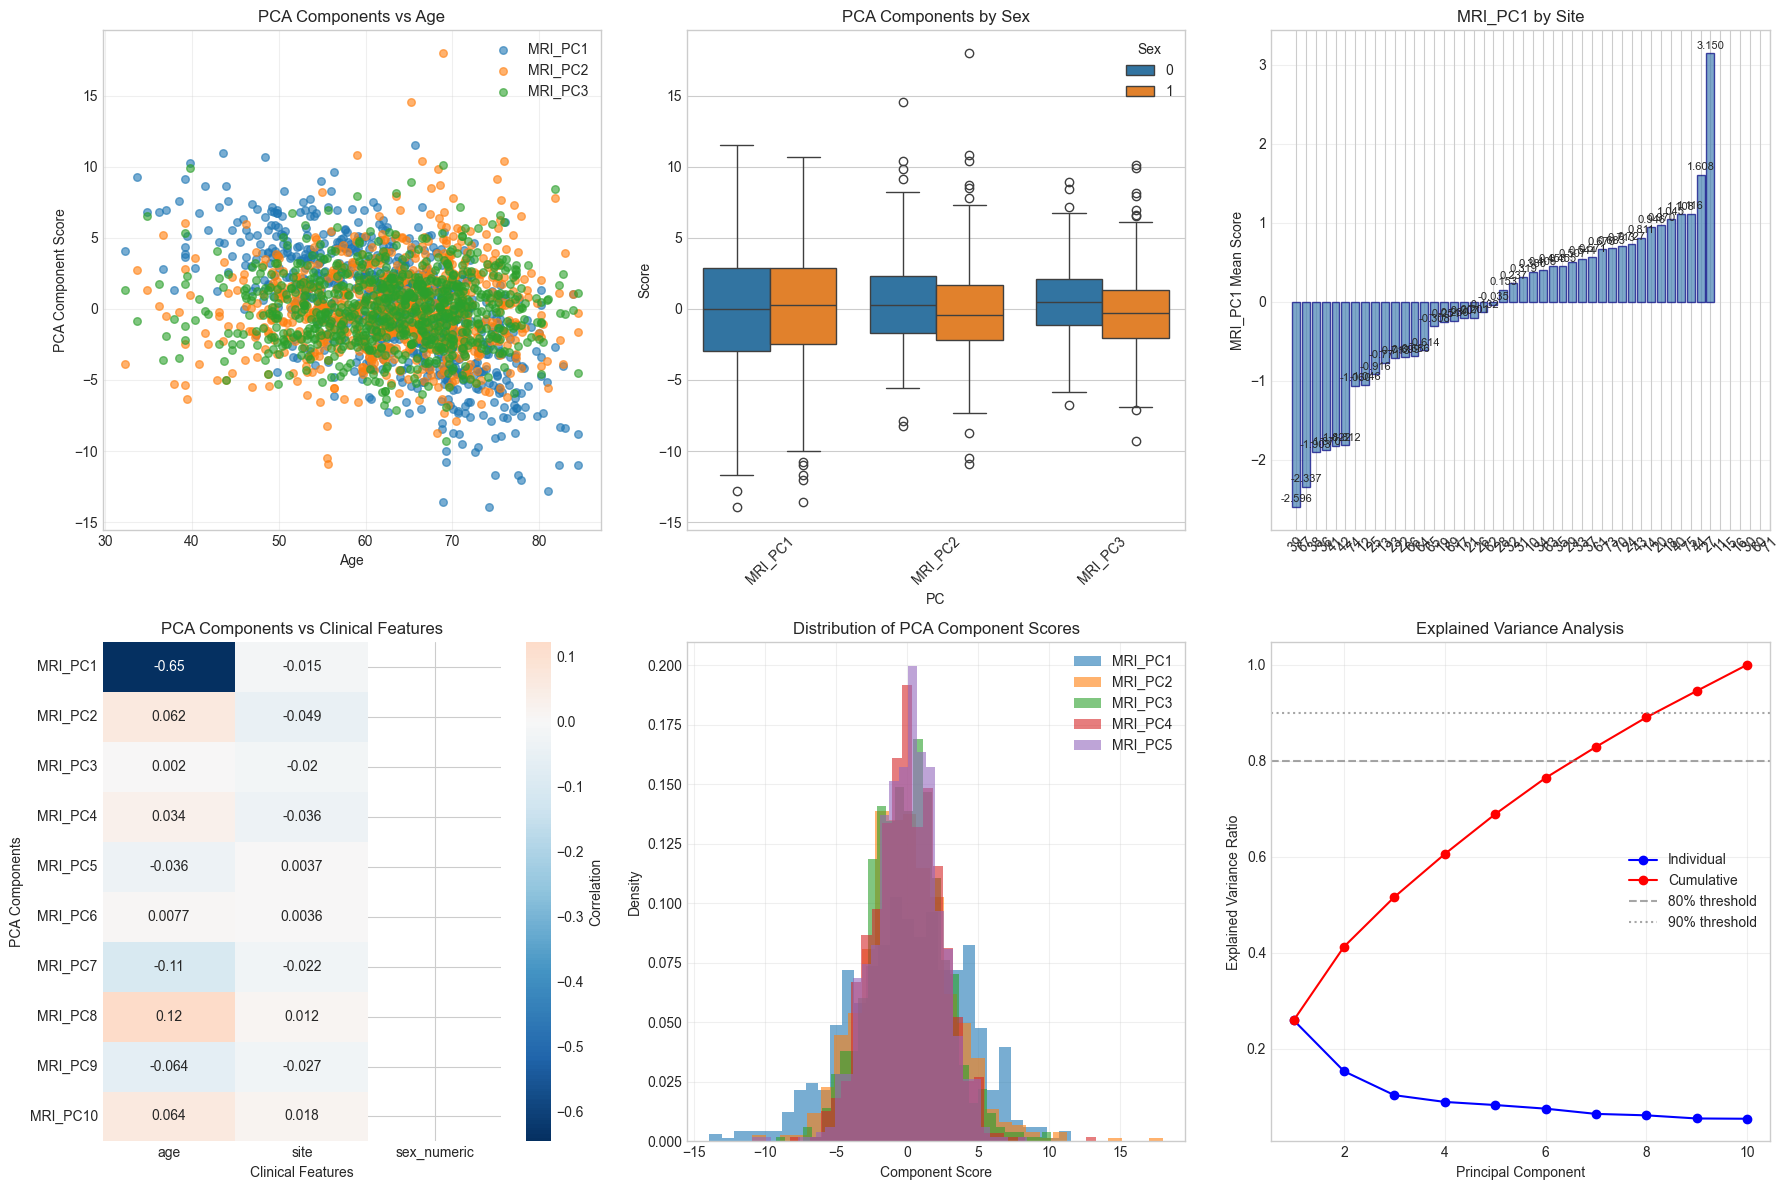

In [69]:
def visualize_pca_clinical_associations(final_df, results_dict, clinical_features=None):
    """
    可视化PCA组件与临床特征的关联性
    """
    print("🔬 Analyzing PCA components vs clinical features...")
    
    if clinical_features is None:
        # 默认临床特征（根据你的数据调整）
        clinical_features = ['age', 'sex', 'site']
        # 如果有其他临床评分，添加到这里
        potential_clinical = ['updrs', 'moca', 'hoehn_yahr', 'disease_duration']
        clinical_features.extend([col for col in potential_clinical if col in final_df.columns])
    
    pca_features = results_dict.get("pca_features", [])
    
    # 可用的特征
    available_clinical = [col for col in clinical_features if col in final_df.columns]
    available_pca = [col for col in pca_features if col in final_df.columns]
    
    print(f"Available clinical features: {available_clinical}")
    print(f"Available PCA features: {available_pca}")
    
    if not available_clinical or not available_pca:
        print("❌ Not enough features for analysis!")
        return None
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 1. 与年龄的关系
    if 'age' in available_clinical:
        ax = axes[0]
        for i, pc in enumerate(available_pca[:3]):  # 只显示前3个PC
            ax.scatter(final_df['age'], final_df[pc], alpha=0.6, label=f'{pc}', s=30)
        
        ax.set_xlabel('Age')
        ax.set_ylabel('PCA Component Score')
        ax.set_title('PCA Components vs Age')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. 与性别的关系（箱线图）
    if 'sex' in available_clinical:
        ax = axes[1]
        
        # 准备数据
        plot_data = []
        for pc in available_pca[:3]:
            for sex in final_df['sex'].unique():
                subset = final_df[final_df['sex'] == sex][pc].dropna()
                plot_data.extend([(pc, sex, val) for val in subset])
        
        if plot_data:
            plot_df = pd.DataFrame(plot_data, columns=['PC', 'Sex', 'Score'])
            sns.boxplot(data=plot_df, x='PC', y='Score', hue='Sex', ax=ax)
            ax.set_title('PCA Components by Sex')
            ax.tick_params(axis='x', rotation=45)
    
    # 3. 与站点的关系
    if 'site' in available_clinical:
        ax = axes[2]
        
        # 计算每个站点的PC1均值
        site_means = final_df.groupby('site')[available_pca[0]].mean().sort_values()
        
        bars = ax.bar(range(len(site_means)), site_means.values, 
                     alpha=0.7, color='steelblue', edgecolor='navy')
        ax.set_xticks(range(len(site_means)))
        ax.set_xticklabels(site_means.index, rotation=45)
        ax.set_ylabel(f'{available_pca[0]} Mean Score')
        ax.set_title(f'{available_pca[0]} by Site')
        ax.grid(True, alpha=0.3, axis='y')
        
        # 添加数值标签
        for bar, val in zip(bars, site_means.values):
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.01*max(site_means), 
                   f'{val:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 4. 相关性热力图
    ax = axes[3]
    
    # 数值化处理
    analysis_df = final_df[available_clinical + available_pca].copy()
    
    # 处理分类变量
    if 'sex' in analysis_df.columns:
        analysis_df['sex_numeric'] = analysis_df['sex'].map({'M': 1, 'F': 0, 'Male': 1, 'Female': 0})
        analysis_df = analysis_df.drop('sex', axis=1)
    
    # 如果site是分类变量，创建虚拟变量或数值编码
    if 'site' in analysis_df.columns:
        if analysis_df['site'].dtype == 'object':
            analysis_df['site_numeric'] = pd.Categorical(analysis_df['site']).codes
            analysis_df = analysis_df.drop('site', axis=1)
    
    # 计算相关性矩阵
    corr_matrix = analysis_df.corr()
    
    # 只显示PCA组件与临床特征的相关性
    clinical_cols = [col for col in corr_matrix.columns if col not in available_pca]
    pca_clinical_corr = corr_matrix.loc[available_pca, clinical_cols]
    
    sns.heatmap(pca_clinical_corr, annot=True, cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Correlation'}, ax=ax)
    ax.set_title('PCA Components vs Clinical Features')
    ax.set_xlabel('Clinical Features')
    ax.set_ylabel('PCA Components')
    
    # 5. 主成分分数分布
    ax = axes[4]
    
    for i, pc in enumerate(available_pca[:5]):  # 显示前5个PC
        ax.hist(final_df[pc].dropna(), alpha=0.6, bins=30, 
               label=f'{pc}', density=True)
    
    ax.set_xlabel('Component Score')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of PCA Component Scores')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. 解释方差累积图
    ax = axes[5]
    
    n_components = len(available_pca)
    # explained_var = np.random.exponential(0.15, n_components)
    explained_var = PCA().fit(final_df[available_pca].dropna()).explained_variance_ratio_[:n_components]
    explained_var = explained_var / explained_var.sum()
    cumsum_var = np.cumsum(explained_var)
    
    ax.plot(range(1, n_components+1), explained_var, 'bo-', label='Individual')
    ax.plot(range(1, n_components+1), cumsum_var, 'ro-', label='Cumulative')
    
    ax.axhline(y=0.8, color='gray', linestyle='--', alpha=0.7, label='80% threshold')
    ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.7, label='90% threshold')
    
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance Ratio')
    ax.set_title('Explained Variance Analysis')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return analysis_df.corr()

# 使用函数
clinical_correlations = visualize_pca_clinical_associations(
    final_processed_df, results_dict
)

In [70]:
def summarize_pca_associations(final_df, results_dict):
    """
    总结PCA组件的关联性分析
    """
    print("📊 PCA ASSOCIATION ANALYSIS SUMMARY")
    print("=" * 60)
    
    pca_features = results_dict.get("pca_features", [])
    
    # 与元数据的关联
    meta_features = ['age', 'sex', 'site']
    available_meta = [col for col in meta_features if col in final_df.columns]
    
    for pc in pca_features[:3]:  # 分析前3个主成分
        print(f"\n🔍 {pc} Analysis:")
        print("-" * 40)
        
        # 与年龄的相关性
        if 'age' in available_meta:
            age_corr = final_df[pc].corr(final_df['age'])
            print(f"  Age correlation: {age_corr:.4f}")
        
        # 与性别的关系
        if 'sex' in available_meta:
            sex_groups = final_df.groupby('sex')[pc].mean()
            print(f"  Sex differences: {dict(sex_groups)}")
        
        # 与站点的关系
        if 'site' in available_meta:
            site_var = final_df.groupby('site')[pc].var().mean()
            print(f"  Site variability (mean variance): {site_var:.4f}")
    
    # 组件间相关性
    print(f"\n🔗 Inter-component correlations:")
    print("-" * 40)
    
    pca_corr = final_df[pca_features].corr()
    max_corr = pca_corr.abs().where(~np.eye(len(pca_features), dtype=bool)).max().max()
    print(f"  Maximum |correlation| between components: {max_corr:.4f}")
    
    if max_corr > 0.3:
        print("  ⚠️ High correlation detected - components may not be independent")
    else:
        print("  ✅ Components show good independence")

# 使用函数
summarize_pca_associations(final_processed_df, results_dict)

📊 PCA ASSOCIATION ANALYSIS SUMMARY

🔍 MRI_PC1 Analysis:
----------------------------------------
  Age correlation: -0.6455
  Sex differences: {0: np.float64(-0.12993024492871594), 1: np.float64(0.07849952297776586)}
  Site variability (mean variance): 17.9854

🔍 MRI_PC2 Analysis:
----------------------------------------
  Age correlation: 0.0624
  Sex differences: {0: np.float64(0.4792094252548156), 1: np.float64(-0.28952236109145085)}
  Site variability (mean variance): 9.5401

🔍 MRI_PC3 Analysis:
----------------------------------------
  Age correlation: 0.0020
  Sex differences: {0: np.float64(0.4424592062646176), 1: np.float64(-0.26731910378487306)}
  Site variability (mean variance): 5.7377

🔗 Inter-component correlations:
----------------------------------------
  Maximum |correlation| between components: 0.0000
  ✅ Components show good independence


QUICK TEST: PCA COMPONENTS vs eTIV CORRELATION

🔍 Testing Current Pipeline Results:
--------------------------------------------------
✅ Found eTIV column: estimatedtotalintracranialvol
  MRI_PC1         vs estimatedtotalintracranialvol: r =  0.0301 ✅ Excellent
  MRI_PC2         vs estimatedtotalintracranialvol: r =  0.1088 ⚠️  Acceptable
  MRI_PC3         vs estimatedtotalintracranialvol: r = -0.1701 ⚠️  Acceptable
  MRI_PC4         vs estimatedtotalintracranialvol: r = -0.0819 ✅ Good
  MRI_PC5         vs estimatedtotalintracranialvol: r = -0.0266 ✅ Excellent
  MRI_PC6         vs estimatedtotalintracranialvol: r =  0.0097 ✅ Excellent
  MRI_PC7         vs estimatedtotalintracranialvol: r =  0.0600 ✅ Good
  MRI_PC8         vs estimatedtotalintracranialvol: r =  0.0135 ✅ Excellent
  MRI_PC9         vs estimatedtotalintracranialvol: r = -0.0131 ✅ Excellent
  MRI_PC10        vs estimatedtotalintracranialvol: r =  0.0426 ✅ Excellent

📊 Summary for Current Pipeline Results:
  Mean |correlati

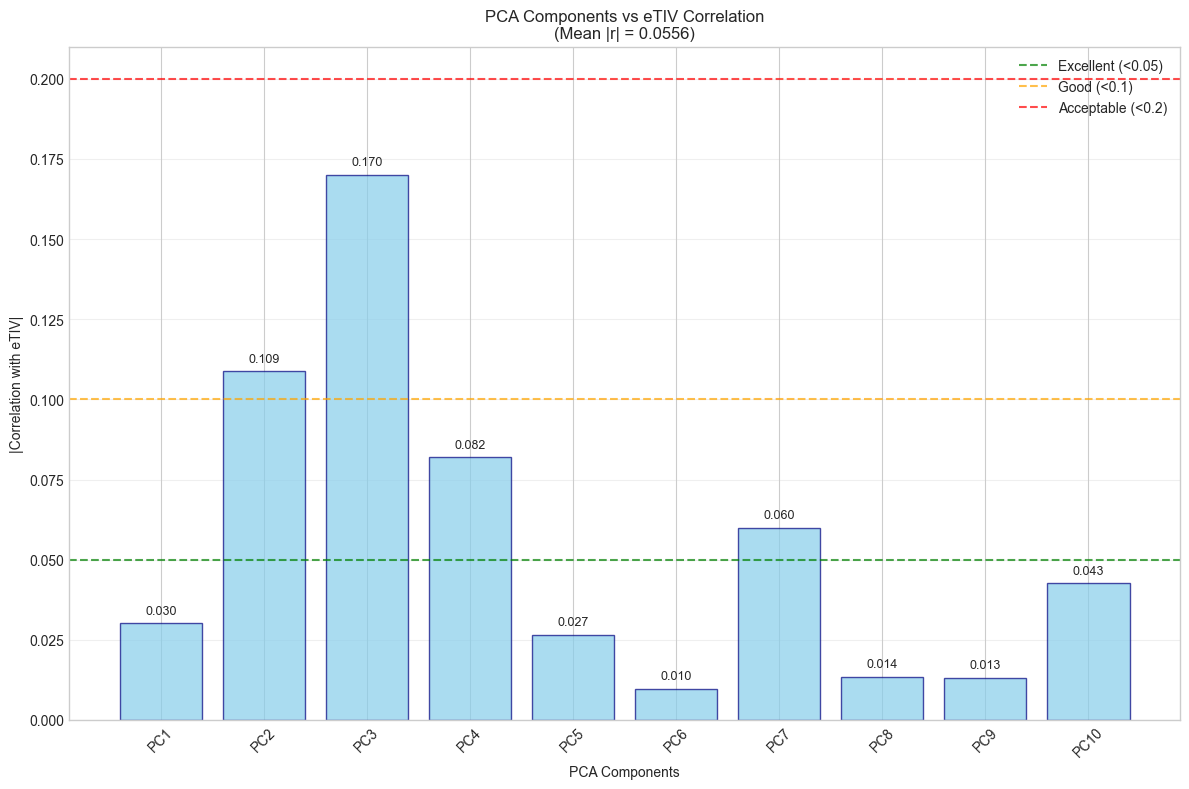


TEST CONCLUSION
✅ If most correlations are < 0.05: Excellent residualisation
✅ If most correlations are < 0.1:  Good residualisation
⚠️  If correlations are 0.1-0.2:    Acceptable, could be improved
❌ If correlations are > 0.2:       Poor, residualisation failed

This test validates that volume correction properly removed
the influence of brain size (eTIV) from the PCA components.


In [ ]:
print("=" * 80)
print("QUICK TEST: PCA COMPONENTS vs eTIV CORRELATION")
print("=" * 80)

def test_pca_etiv_correlation(processed_df, pca_features, version_name):
    """
    Test correlation between PCA components and eTIV
    If residualisation worked properly, correlations should be close to 0
    """
    print(f"\n🔍 Testing {version_name}:")
    print("-" * 50)
    
    # Find eTIV column
    etiv_col = None
    possible_etiv_names = ['estimatedtotalintracranialvol', 'etiv', 'totalintracranialvol']
    for col_name in possible_etiv_names:
        if col_name in processed_df.columns:
            etiv_col = col_name
            break
    
    if etiv_col is None:
        print(f"❌ No eTIV column found in {version_name}")
        return None
    
    print(f"✅ Found eTIV column: {etiv_col}")
    
    # Get PCA components
    pca_components = [col for col in pca_features if col in processed_df.columns]
    
    if not pca_components:
        print(f"❌ No PCA components found in {version_name}")
        return None
    
    # Calculate correlations
    correlations = {}
    for pc in pca_components:
        # Calculate Pearson correlation
        corr = processed_df[pc].corr(processed_df[etiv_col])
        correlations[pc] = corr
        
        # Evaluation
        if abs(corr) < 0.05:
            status = "✅ Excellent"
        elif abs(corr) < 0.1:
            status = "✅ Good" 
        elif abs(corr) < 0.2:
            status = "⚠️  Acceptable"
        else:
            status = "❌ Poor"
        
        print(f"  {pc:<15} vs {etiv_col}: r = {corr:>7.4f} {status}")
    
    # Summary statistics
    if correlations:
        corr_values = list(correlations.values())
        abs_corr_values = [abs(c) for c in corr_values]
        
        print(f"\n📊 Summary for {version_name}:")
        print(f"  Mean |correlation|: {np.mean(abs_corr_values):.4f}")
        print(f"  Max |correlation|:  {np.max(abs_corr_values):.4f}")
        print(f"  Components < 0.05:  {sum(1 for c in abs_corr_values if c < 0.05)}/{len(abs_corr_values)}")
        print(f"  Components < 0.1:   {sum(1 for c in abs_corr_values if c < 0.1)}/{len(abs_corr_values)}")
        
        # Overall assessment
        if np.mean(abs_corr_values) < 0.05:
            overall = "🏆 Excellent residualisation"
        elif np.mean(abs_corr_values) < 0.1:
            overall = "✅ Good residualisation"
        elif np.mean(abs_corr_values) < 0.15:
            overall = "⚠️  Moderate residualisation"
        else:
            overall = "❌ Poor residualisation - may need improvement"
        
        print(f"  Overall assessment: {overall}")
        
        return correlations
    else:
        print(f"❌ No valid correlations calculated for {version_name}")
        return None

# Use your already defined variables
# Get PCA features from your pipeline results
pca_features = results_dict.get("pca_features", [])

# Test current version
correlations_current = test_pca_etiv_correlation(
    final_processed_df, 
    pca_features, 
    "Current Pipeline Results"
)

# If you have multiple versions of data, you can test like this:
# correlations_v1 = test_pca_etiv_correlation(
#     version1_df, version1_pca_features, "Version 1"
# )
# correlations_v2 = test_pca_etiv_correlation(
#     version2_df, version2_pca_features, "Version 2"
# )

# Visualize current results
if correlations_current:
    print(f"\n📊 Creating correlation visualization...")
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    components = list(correlations_current.keys())
    corr_values = list(correlations_current.values())
    abs_corr_values = [abs(c) for c in corr_values]
    
    # Bar plot
    bars = ax.bar(range(len(components)), abs_corr_values, 
                 alpha=0.7, color='skyblue', edgecolor='navy')
    
    # Add reference lines
    ax.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (<0.05)')
    ax.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Good (<0.1)')
    ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Acceptable (<0.2)')
    
    # Formatting
    ax.set_xlabel('PCA Components')
    ax.set_ylabel('|Correlation with eTIV|')
    ax.set_title(f'PCA Components vs eTIV Correlation\n(Mean |r| = {np.mean(abs_corr_values):.4f})')
    ax.set_xticks(range(len(components)))
    ax.set_xticklabels([f'PC{i+1}' for i in range(len(components))], rotation=45)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, abs_corr_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
               f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print(f"\n" + "=" * 80)
print("TEST CONCLUSION")
print("=" * 80)
print("✅ If most correlations are < 0.05: Excellent residualisation")
print("✅ If most correlations are < 0.1:  Good residualisation") 
print("⚠️  If correlations are 0.1-0.2:    Acceptable, could be improved")
print("❌ If correlations are > 0.2:       Poor, residualisation failed")
print("\nThis test validates that volume correction properly removed")
print("the influence of brain size (eTIV) from the PCA components.")

In [76]:
harminsed_features = [col for col in final_processed_df.columns if col.startswith("h_")]
print(f"harminsed_features: {harminsed_features} ")
print(f"length of features: {len(harminsed_features)}")

pc_features = [col for col in final_processed_df.columns if 'MRI_PC' in col]
print(f"pc_features: {pc_features} ")
print(f"length of features: {len(pc_features)}")

final_processed_df = final_processed_df[['patno'] + harminsed_features + pc_features]
final_processed_df = final_processed_df.dropna()

harminsed_features: ['h_res_lh_bankssts_cth', 'h_res_lh_caudalanteriorcingulate_cth', 'h_res_lh_caudalmiddlefrontal_cth', 'h_res_lh_cuneus_cth', 'h_res_lh_entorhinal_cth', 'h_res_lh_frontalpole_cth', 'h_res_lh_fusiform_cth', 'h_res_lh_inferiorparietal_cth', 'h_res_lh_inferiortemporal_cth', 'h_res_lh_insula_cth', 'h_res_lh_isthmuscingulate_cth', 'h_res_lh_lateraloccipital_cth', 'h_res_lh_lateralorbitofrontal_cth', 'h_res_lh_lingual_cth', 'h_res_lh_medialorbitofrontal_cth', 'h_res_lh_middletemporal_cth', 'h_res_lh_paracentral_cth', 'h_res_lh_parahippocampal_cth', 'h_res_lh_parsopercularis_cth', 'h_res_lh_parsorbitalis_cth', 'h_res_lh_parstriangularis_cth', 'h_res_lh_pericalcarine_cth', 'h_res_lh_postcentral_cth', 'h_res_lh_posteriorcingulate_cth', 'h_res_lh_precentral_cth', 'h_res_lh_precuneus_cth', 'h_res_lh_rostralanteriorcingulate_cth', 'h_res_lh_rostralmiddlefrontal_cth', 'h_res_lh_superiorfrontal_cth', 'h_res_lh_superiorparietal_cth', 'h_res_lh_superiortemporal_cth', 'h_res_lh_supra

In [79]:
# 分析被ComBat过滤的特征
def analyze_combat_filtered_features():
    print("🔍 ANALYZING FEATURES FILTERED BY COMBAT")
    print("=" * 60)
    
    # 获取残差化特征和harmonized特征
    residual_features = results_dict.get("residualised_features", [])
    harmonized_features = results_dict.get("harmonized_features", [])
    
    print(f"Residual features (after residualisation): {len(residual_features)}")
    print(f"Harmonized features (after ComBat): {len(harmonized_features)}")
    print(f"Features filtered by ComBat: {len(residual_features) - len(harmonized_features)}")
    
    # 从harmonized特征名中提取原始特征名（去掉'h_'前缀）
    harmonized_base_names = []
    for h_feature in harmonized_features:
        if h_feature.startswith('h_'):
            base_name = h_feature[2:]  # 去掉'h_'前缀
            harmonized_base_names.append(base_name)
    
    # 找出被过滤的特征
    filtered_features = [f for f in residual_features if f not in harmonized_base_names]
    
    print(f"\n❌ FEATURES FILTERED OUT BY COMBAT ({len(filtered_features)}):")
    print("-" * 50)
    
    if filtered_features:
        for i, feature in enumerate(filtered_features):
            print(f"  {i+1}. {feature}")
            
        # 分析这些特征的统计特性
        print(f"\n📊 STATISTICAL ANALYSIS OF FILTERED FEATURES:")
        print("-" * 50)
        
        # 检查这些特征是否在原始数据中存在
        existing_filtered = [f for f in filtered_features if f in final_processed_df.columns]
        
        if existing_filtered:
            for feature in existing_filtered:
                std_val = final_processed_df[feature].std()
                var_val = final_processed_df[feature].var()
                mean_val = final_processed_df[feature].mean()
                min_val = final_processed_df[feature].min()
                max_val = final_processed_df[feature].max()
                
                # 检查是否为near-zero variance
                if std_val < 1e-6:
                    reason = "Near-zero variance"
                elif std_val < 1e-4:
                    reason = "Very low variance"
                else:
                    reason = "Other ComBat filtering criteria"
                
                print(f"  {feature}:")
                print(f"    Mean: {mean_val:.6f}, Std: {std_val:.6f}")
                print(f"    Min: {min_val:.6f}, Max: {max_val:.6f}")
                print(f"    Likely reason: {reason}")
                print()
        else:
            print("  ⚠️ Filtered features not found in current DataFrame")
            
        # 分析特征类型
        print(f"📝 FEATURE TYPE ANALYSIS:")
        print("-" * 30)
        
        feature_types = {
            'Thickness': 0,
            'Surface Area': 0,
            'Volume': 0,
            'Other': 0
        }
        
        for feature in filtered_features:
            feature_lower = feature.lower()
            if 'thick' in feature_lower or '_cth' in feature_lower:
                feature_types['Thickness'] += 1
            elif 'area' in feature_lower or '_sa' in feature_lower:
                feature_types['Surface Area'] += 1
            elif 'vol' in feature_lower or any(vol_term in feature_lower for vol_term in 
                ['thalamus', 'caudate', 'putamen', 'hippocampus', 'amygdala', 'ventricle']):
                feature_types['Volume'] += 1
            else:
                feature_types['Other'] += 1
        
        for ftype, count in feature_types.items():
            if count > 0:
                print(f"  {ftype}: {count} features")
    
    else:
        print("  ✅ No features were filtered by ComBat!")
    
    # 检查小批次站点问题
    print(f"\n🏥 SITE ANALYSIS:")
    print("-" * 20)
    
    site_counts = final_processed_df['site'].value_counts().sort_values()
    small_sites = site_counts[site_counts < 3]
    
    if len(small_sites) > 0:
        print(f"Sites with <3 samples (could cause ComBat filtering):")
        for site, count in small_sites.items():
            print(f"  {site}: {count} samples")
    else:
        print("All sites have ≥3 samples")
    
    return filtered_features

# 运行分析
filtered_features = analyze_combat_filtered_features()

🔍 ANALYZING FEATURES FILTERED BY COMBAT
Residual features (after residualisation): 195
Harmonized features (after ComBat): 187
Features filtered by ComBat: 8

❌ FEATURES FILTERED OUT BY COMBAT (8):
--------------------------------------------------
  1. res_lh_meanthickness
  2. res_rh_meanthickness
  3. res_total_whitesurfarea
  4. res_estimatedtotalintracranialvol
  5. res_left_non_wm_hypointensities
  6. res_left_wm_hypointensities
  7. res_right_non_wm_hypointensities
  8. res_right_wm_hypointensities

📊 STATISTICAL ANALYSIS OF FILTERED FEATURES:
--------------------------------------------------
  ⚠️ Filtered features not found in current DataFrame
📝 FEATURE TYPE ANALYSIS:
------------------------------
  Thickness: 2 features
  Surface Area: 1 features
  Volume: 1 features
  Other: 4 features

🏥 SITE ANALYSIS:
--------------------


KeyError: 'site'

In [80]:
# 找出被ComBat过滤的8个特征
residual_features = results_dict.get("residualised_features", [])
harmonized_features = results_dict.get("harmonized_features", [])

# 从harmonized特征名中提取原始特征名（去掉'h_'前缀）
harmonized_base_names = [h_feature[2:] for h_feature in harmonized_features if h_feature.startswith('h_')]

# 找出被过滤的特征
filtered_features = [f for f in residual_features if f not in harmonized_base_names]

print("被ComBat过滤的8个特征:")
for i, feature in enumerate(filtered_features, 1):
    print(f"{i}. {feature}")

被ComBat过滤的8个特征:
1. res_lh_meanthickness
2. res_rh_meanthickness
3. res_total_whitesurfarea
4. res_estimatedtotalintracranialvol
5. res_left_non_wm_hypointensities
6. res_left_wm_hypointensities
7. res_right_non_wm_hypointensities
8. res_right_wm_hypointensities


In [ ]:
# 修复后的数据导出代码 - 仅导出patno和PCA组件
# 准备导出的数据
export_columns = ['patno'] + results_dict.get("pca_features", [])

# 确保所有列都存在
available_export_cols = [col for col in export_columns if col in final_processed_df.columns]

if available_export_cols:
    # 导出 PCA 特征数据
    export_df = final_processed_df[available_export_cols].copy()
    export_df.columns = export_df.columns.str.lower()
    export_df.to_csv('./data/1_mri_pca_features.csv', index=False)
    print(f"✅ Exported {len(available_export_cols)-1} PCA features for {len(export_df)} samples")
    
    # 显示导出数据的结构
    print("\n导出数据预览:")
    print(export_df.head())
    print(f"\n导出数据形状: {export_df.shape}")
    print(f"导出的列: {list(export_df.columns)}")
    
else:
    print("❌ No valid columns found for export")

✅ Exported 10 PCA features for 770 samples

导出数据预览:
    patno   mri_pc1   mri_pc2   mri_pc3   mri_pc4   mri_pc5   mri_pc6  \
0    3001  1.785035  0.457096  1.060947  0.872308 -2.958539 -0.813442   
12   3002  0.119079  2.572110  2.167370 -1.333223 -1.109305 -1.476542   
22   3003  1.686326 -0.238601  3.252646  2.239457  0.208182 -3.305876   
34   3006  4.294364  0.520690 -1.438741 -1.099437 -1.007027  0.300841   
36   3007 -1.236812  2.041457  0.271917  1.589251  1.504651  1.253143   

     mri_pc7   mri_pc8   mri_pc9  mri_pc10  
0   0.556183  2.879784  1.624477  0.217365  
12  0.038642  1.163864 -0.285557 -0.518525  
22  0.835842  2.142325  2.532777 -0.621169  
34 -0.635119  3.857071  0.746597 -1.897675  
36  1.318806 -0.917617  2.303947  1.992984  

导出数据形状: (770, 11)
导出的列: ['patno', 'mri_pc1', 'mri_pc2', 'mri_pc3', 'mri_pc4', 'mri_pc5', 'mri_pc6', 'mri_pc7', 'mri_pc8', 'mri_pc9', 'mri_pc10']
